In [1]:
%matplotlib notebook

-------start--------------
********/Users/astro/Documents/notebooks/zs/result/stackfits/10001-12701.fits************
10001-12701


<IPython.core.display.Javascript object>


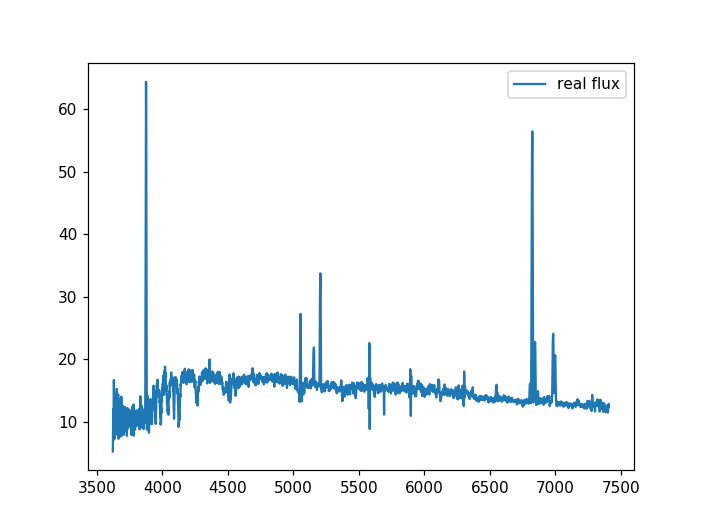

<IPython.core.display.Javascript object>


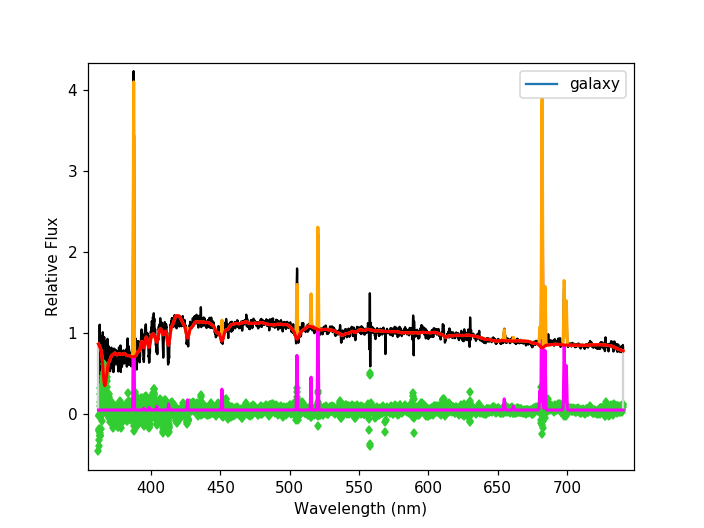

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']
Weighted <logAge> [yr]: 9.96
Weighted <[M/H]>: -0.109
M/L_r: 2.509


<IPython.core.display.Javascript object>


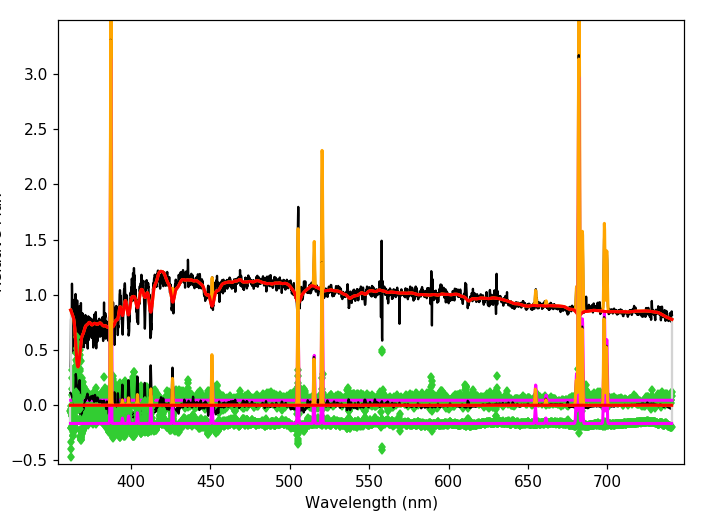

Nonzero Templates: 7 / 150
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']
---------------------------------------------------------


<IPython.core.display.Javascript object>


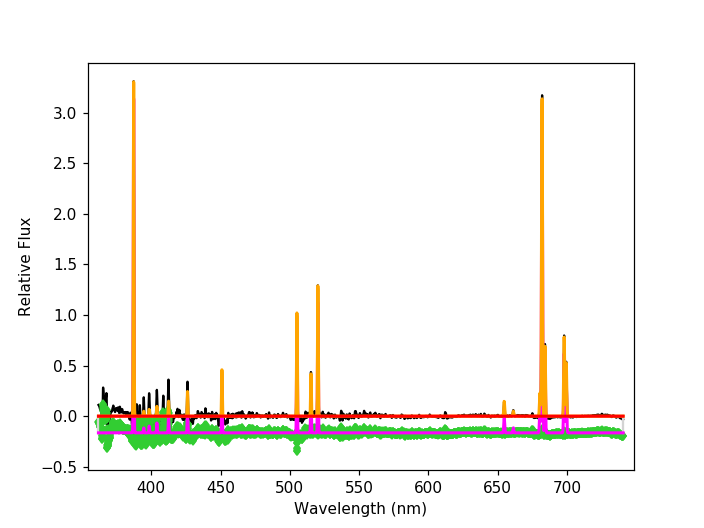

---------end--------


In [12]:
# 2019-04-16:原始的发射线减去连续谱然后进行拟合:
#
import glob
from os import path
from time import perf_counter as clock

import matplotlib.pyplot as plt

import numpy as np
from astropy.io import fits

import ppxf as ppxf_package
import ppxf.miles_util as lib
import ppxf.ppxf_util as util
import ppxf.ppxfgas as gas
from ppxf.ppxf import ppxf
import ppxf.ppxfmpl8 as mpl8
import ppxf.ppxfstellar as stellar


def ppxf_example_population_gas_sdss(flux, galaxy, wave, median_flux, plateifu,
                                     redshift, tie_balmer, limit_doublets):

    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
    # read file
    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_all.txt'
    z = redshift
    # ----------
    # information:
    flux = flux
    median_flux = median_flux
    galaxy = galaxy
    wave = wave
    # ------------
    wave *= np.median(util.vac_to_air(wave) / wave)

    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    noise = np.full_like(galaxy,
                         0.01635)  # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c * np.log(wave[1] / wave[0])  # eq.(8) of Cappellari (2017)
    # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    FWHM_gal = 2.76

    # ------------------- Setup templates -----------------------

    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'

    # The templates are normalized to mean=1 within the FWHM of the V-band.
    # In this way the weights and mean values are light-weighted quantities
    miles = lib.miles(pathname, velscale, FWHM_gal)

    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)]) / (1 + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.log_lam_temp,
        lam_range_gal,
        FWHM_gal,
        tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
    templates = np.column_stack([stars_templates, gas_templates])
    # -----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = 299792.458
    dv = c * (miles.log_lam_temp[0] - np.log(wave[0])
              )  # eq.(8) of Cappellari (2017)
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a
                          for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0] * n_temps + [1] * n_balmer + [2] * n_forbidden
    gas_component = np.array(
        component) > 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [4, 2, 2]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None

    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    t = clock()
    pp = mpl8.ppxf(dirfile,
                   templates,
                   galaxy,
                   median_flux,
                   noise,
                   velscale,
                   start,
                   plot=True,
                   moments=moments,
                   degree=-1,
                   mdegree=10,
                   vsyst=dv,
                   lam=wave,
                   clean=False,
                   regul=1. / regul_err,
                   reg_dim=reg_dim,
                   component=component,
                   gas_component=gas_component,
                   gas_names=gas_names,
                   gas_reddening=gas_reddening)

    # When the two Delta Chi^2 below are the same, the solution
    # is the smoothest consistent with the observed spectrum.
    #
    #     print('Desired Delta Chi^2: %.4g' % np.sqrt(2 * galaxy.size))
    #     print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1) * galaxy.size))
    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    weights = pp.weights[
        ~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim) / weights.sum()  # Normalized

    miles.mean_age_metal(weights)
    miles.mass_to_light(weights, band="r")

    # Plot fit results for stars and gas.
    plt.figure()
    plt.clf()
    pp.plot()
    #     print(pp.gas_names, pp.gas_flux, pp.bestfit)

    # Plot stellar population mass fraction distribution
    #     plt.subplot(212)
    #     miles.plot(weights)
    plt.tight_layout()
    #     plt.ylim(0)
    #     plt.pause(1)
    return pp.bestfit, pp.lam, np.mean(flux)


def ppxf_example_kinematics_sdss(flux, galaxy, lam_gal, plateifu, mask,
                                 redshift):

    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    # Read SDSS DR12 galaxy spectrum taken from here http://dr12.sdss3.org/
    # The spectrum is *already* log rebinned by the SDSS DR12
    # pipeline and log_rebin should not be used in this case.

    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_stellar.txt'

    z = redshift
    flux = flux
    galaxy = galaxy
    lam_gal = lam_gal
    mask = mask
    noise = np.full_like(galaxy, 0.0166)
    c = 299792.458
    frac = lam_gal[1] / lam_gal[0]
    dlamgal = (frac - 1) * lam_gal
    #     print('dla', dlamgal)
    a = np.full((1, 4563), 2.76)
    fwhm_gal = a[0][mask]

    velscale = np.log(frac) * c

    # If the galaxy is at significant redshift, one should bring the galaxy
    # spectrum roughly to the rest-frame wavelength, before calling pPXF
    # (See Sec.2.4 of Cappellari 2017). In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    # lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    # fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
    # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    fwhm_tem = 2.51

    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SDSS galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lam_temp = h2['CRVAL1'] + h2['CDELT1'] * np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif / 2.355 / h2['CDELT1']  # Sigma difference in pixels

    for j, fname in enumerate(vazdekis):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        ssp = util.gaussian_filter1d(
            ssp, sigma)  # perform convolution with variable sigma
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
        templates[:, j] = sspNew / np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0] / lam_gal[0]) * c  # km/s
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 200.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = stellar.ppxf(dirfile,
                      templates,
                      galaxy,
                      noise,
                      velscale,
                      start,
                      goodpixels=goodpixels,
                      plot=False,
                      moments=4,
                      degree=12,
                      vsyst=dv,
                      clean=False,
                      lam=lam_gal)

    #     print("Formal errors:")
    #     print("     dV    dsigma   dh3      dh4")
    #     print("".join("%8.2g" % f for f in pp.error * np.sqrt(pp.chi2)))

    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    return pp.bestfit, pp.lam, np.mean(flux)

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1


def emission(w1, f1, redshift, plateifu, tie_balmer, limit_doublets):
    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_emission_line.txt'

    z = redshift
    flux = f1
    galaxy = flux
    wave = w1

    wave *= np.median(util.vac_to_air(wave) / wave)

    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    noise = np.full_like(galaxy,
                         0.01635)  # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c * np.log(wave[1] / wave[0])  # eq.(8) of Cappellari (2017)
    # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    FWHM_gal = 2.76

    # ------------------- Setup templates -----------------------

    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'

    # The templates are normalized to mean=1 within the FWHM of the V-band.
    # In this way the weights and mean values are light-weighted quantities
    miles = lib.miles(pathname, velscale, FWHM_gal)

    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    #     stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)]) / (1 + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.log_lam_temp,
        lam_range_gal,
        FWHM_gal,
        tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
    templates = gas_templates
    # -----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = 299792.458
    dv = c * (miles.log_lam_temp[0] - np.log(wave[0])
              )  # eq.(8) of Cappellari (2017)
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    #     n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a
                          for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0] * n_balmer + [1] * n_forbidden
    gas_component = np.array(
        component) >= 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [2, 2]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None

    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    t = clock()
    pp = gas.ppxf(dirfile,
                  templates,
                  galaxy,
                  noise,
                  velscale,
                  start,
                  plot=True,
                  moments=moments,
                  degree=-1,
                  mdegree=10,
                  vsyst=dv,
                  lam=wave,
                  clean=False,
                  component=component,
                  gas_component=gas_component,
                  gas_names=gas_names,
                  gas_reddening=gas_reddening)

    # When the two Delta Chi^2 below are the same, the solution
    # is the smoothest consistent with the observed spectrum.
    #
    #     print('Desired Delta Chi^2: %.4g' % np.sqrt(2 * galaxy.size))
    #     print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1) * galaxy.size))
    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    #     weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    #     weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

    #     miles.mean_age_metal(weights)
    #     miles.mass_to_light(weights, band="r")

    plt.figure()
    # Plot fit results for stars and gas.
    plt.clf()
    pp.plot()
    #     print(pp.gas_names, pp.gas_flux, pp.bestfit)

    # Plot stellar population mass fraction distribution

    return pp.bestfit, pp.lam


if __name__ == '__main__':
    dir1 = '/Users/astro/Documents/notebooks/zs/result/stackfits/'
    z = fits.open('/Users/astro/Documents/notebooks/zs/ppxf_yxl/z_mpl8.fits')
    data = z[1].data
    pifu = data.field('PLATEIFU')
    z_info = data.field('Z')
    all_file = glob.glob(dir1 + '*.fits')
    for j in range(0, 1):
        i = all_file[j]
        #         dirfile='/home/zhaisai/zhaisai/result/mpl8/2019_04_17_new/'+i[48:-5]+'_all.txt'
        dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
            '10001-12701'+'_stellar.txt'
        if path.exists(dirfile):
            continue
        else:
            print('-------start--------------')
            print('********' + i + '************')
            #             plateifu=i[48:-5]
            plateifu = '10001-12701'
            print(plateifu)
            index = np.where(pifu == plateifu)[0]
            z1 = z_info[index]
            file = fits.open(i)
            t = file[1].data
            mask1 = (t['col0'] > 3540) & (t['col0'] < 7409)
            m = 0
            for q in t.columns:
                m += 1
            if m >= 4:
                flux = t['col3'][mask1]
                galaxy = flux / np.median(flux)
                wave = t['col0'][mask1]
                plt.figure()
                plt.plot(wave, flux, label='real flux')

                plt.legend()
                plt.figure()
                plt.plot(wave, galaxy, label='galaxy')
                plt.legend()
                f1, w1, mean_f1 = ppxf_example_population_gas_sdss(
                    flux,
                    galaxy,
                    wave,
                    np.median(flux),
                    plateifu,
                    z1,
                    tie_balmer=True,
                    limit_doublets=False)
                f2, w2, mean_f2 = ppxf_example_kinematics_sdss(
                    flux, galaxy, wave, plateifu, mask1, z1)
                emission(w1,
                         f1 - f2,
                         z1,
                         plateifu,
                         tie_balmer=True,
                         limit_doublets=False)
                print('---------end--------')

            else:
                print('----no-----')
                
                
                
           # orange: galaxy
        # magenta: emission line;

In [11]:
pwd

'/Users/astro/Documents/notebooks/zs/ppxf_v2'

# z_do2

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from astropy.io import fits
from astropy.table import Table
from scipy.misc import derivative

np.seterr(divide='ignore', invalid='ignore')


def do2(xi, xi_e):
    metal = []
    sigma = []
    for i in range(0, len(xi), 1):
        x = xi[i]
        x_e = xi_e[i]
        metal.append(9.12 + 0.73 * x)
        sigma.append(0.73 * x_e)
    return np.array(metal), np.array(sigma)


def rred(wl, f, f_e, e_bv):
    k_ha = 1.17 * (-1.857 + 1.040 / 0.6564) + 1.78
    k_hb = 1.17 * (-2.156 + 1.509 / 0.4862 - 0.198 / (0.4862**2) + 0.011 /
                    (0.4862**3)) + 1.78
    a = f
    wl = wl / 10000.0
    if 0.63 <= wl <= 2.2:
        k = 1.17 * (-1.857 + 1.040 / wl) + 1.78
    elif 0.12 <= wl <= 0.63:
        k = 1.17 * (-2.156 + 1.509 / wl - 0.198 / (wl**2) + 0.011 /
                     (wl**3)) + 1.78
    f = sy.symbols('f')
    y = f * 10**(0.4 * k * e_bv)
    y_df = sy.diff(y, f)
    df = float(y_df.subs({f: a}))
    sigma = sy.sqrt(df**2 * float(f_e)**2)
    return float(y.subs({f: a})), sigma

dir1 = '/Users/astro/Documents/notebooks/zs/pair-m-z/res/'  # result
dir2 = '/Users/astro/Documents/notebooks/zs/data/'  # data
f_emi_miss=open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/'+'z_do2_miss_emis_10_25.info','a+')
f_info = open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/' + 'z_do2_10_25.txt', 'a+')
f_nomass=open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/z_do2__10_25_no_mass.info','a+')
dir3='/Users/astro/Documents/notebooks/zs/2019-09-17/' # stellar mass file
print('PLATEIFU',
      'ebv',
      'mag_r',
      'mag_i',
      'mass_median',
      'mass_p16',
      'mass_p84',
      'mass_p2p5',
      'mass_p97p5',
      'mass_mode',
      'mass_avg',
      'balmer',
      'balmer_err',
      'NII',
      'NII_e',
      'Hbeta',
      'Hbeta_e',
      'Halpha',
      'Halpha_e',
      'NII_r',
      'NII_e_r',
      'Hbeta_r',
      'Hbeta_e_r',
      'Halpha_r',
      'Halpha_e_r',
      'z_do2',
      'z_do2_e',
      file=f_info)


emissionfile = glob.glob(dir1 + '*show*')

# 获取星等信息
f_mag = fits.open(dir2 + 'drpall-v2_5_3.fits')
data = f_mag[1].data
mag = data.field('nsa_sersic_absmag')
mag_plateifu = data.field('plateifu')

# 获取stellar mass信息：
f_mass=fits.open(dir3+'dr7_mpl8')
data1=f_mass[1].data
mass_median=data1['MEDIAN']
mass_p16=data1['P16']
mass_p84=data1['P84']
mass_p2p5=data1['P2P5']
mass_p97p5=data1['P97P5']
mass_mode=data1['MODE']
mass_avg=data1['AVG']
mass_plateifu=data1['plateifu']


print('_____________start')
j = 0
for i in range(0, len(emissionfile)):
    filename = emissionfile[i]
    j += 1
    len1=len(dir1) # dir1 的长度
    len2=len('_show.jpg') # 后缀的长度

    if os.path.exists(filename[:-len2]+'.txt'):        
        col0 = filename[len1:]
        plateifu = col0[:-len2]
        index = np.where(mag_plateifu == plateifu)[0]
        # mag 数据获取
        mag1 = mag[index]
        # stellar mass 数据获取
        index1= np.where(mass_plateifu==plateifu)[0]
        if len(index1)>0:
            mass_median1=mass_median[index1[0]]
            mass_p16_1=mass_p16[index1[0]]
            mass_p84_1=mass_p84[index1[0]]
            mass_p2p5_1=mass_p2p5[index1[0]]
            mass_p97p5_1=mass_p97p5[index1[0]]
            mass_mode1=mass_mode[index1[0]]
            mass_avg1=mass_avg[index1[0]]
        else:
            print('plateifu without mass info: ',plateifu, file=f_nomass)   
            mass_p16_1=mass_p84_1=mass_p2p5_1=mass_p97p5_1=mass_mode1=mass_avg1=-99
        # 读取flux数据信息:
        print(filename)
        f = open(filename[:-len2]+'.txt', 'r')
        line = f.readlines()
        print(line[13])
        e_bv = float(line[13][21:])
        info = []
        for i in range(20, len(line)):
            info.append(line[i])
        flux1 = [i.strip().split()[3] for i in info]
        flux1 = map(float, flux1)
        flux1 = list(flux1)
        name1 = [i.strip().split()[2] for i in info]
        err = [i.strip().split()[4] for i in info]
        # 计算结果
        if 'Balmer' in name1 and'[NII]6583_d' in name1:
            if flux1[name1.index('Balmer')] > 0 and flux1[name1.index('[NII]6583_d')]>0:
                nii = flux1[name1.index('[NII]6583_d')]
                nii_err = err[name1.index('[NII]6583_d')]
                balmer = flux1[name1.index('Balmer')]
                balmer_err = err[name1.index('Balmer')]

                #                 print('balmer',type(balmer),type(ratio),type(balmer_err))
                ratio = 0.0530 + 0.0731 + 0.105 + 0.159 + 0.259 + 0.468 + 1 + 2.86
                halpha = balmer * 2.86 / ratio
                halpha_err = float(balmer_err) * 2.86 / ratio
                hbeta = balmer / ratio
                hbeta_err = float(balmer_err) / ratio

                # 消光改正

                nii_r, nii_err_r = rred(6583, nii, nii_err, e_bv)
                halpha_r, halpha_err_r = rred(6563, halpha, halpha_err, e_bv)
                hbeta_r, hbeta_err_r = rred(4861, hbeta, hbeta_err, e_bv)

                # function
                a, f, a1, f1 = sy.symbols('a f a1 f1')
                f_n2 = sy.log(a / f, 10)
                # diff
                df_n2_a = sy.diff(f_n2, a)
                df_n2_f = sy.diff(f_n2, f)
                # error
                sigma_n2 = sy.sqrt((df_n2_a * a1)**2 + (df_n2_f * f1)**2)

                n2_err = float(
                    sigma_n2.subs({
                        a: nii_r,
                        a1: nii_err_r,
                        f: halpha_r,
                        f1: halpha_err_r
                    }))

                # 数据
                print(nii_r,halpha_r)
                n2 = float(f_n2.subs({a: nii_r, f: halpha_r}))

                # 计算金属丰度
                z_do2, z_do2_e = do2([n2], [n2_err])

                print(plateifu,
                      e_bv,
                      mag1[0, 4],
                      mag1[0, 5],
                      mass_median1,
                      mass_p16_1,
                      mass_p84_1,
                      mass_p2p5_1,
                      mass_p97p5_1,
                      mass_mode1,
                      mass_avg1,
                      balmer,
                      balmer_err,
                      nii,
                      nii_err,
                      hbeta,
                      hbeta_err,
                      halpha,
                      halpha_err,
                      nii_r,
                      nii_err_r,
                      hbeta_r,
                      hbeta_err_r,
                      halpha_r,
                      halpha_err_r,
                      z_do2[0],
                      z_do2_e[0],
                      file=f_info)

            else:
                print('file missing emission line info',filename,file=f_emi_miss)        
        

f_info.close()
f_emi_miss.close()
f_nomass.close()
print('___________finished')

_____________start
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12701_show.jpg
Gas Reddening E(B-V): 0.273

10.503479298237488 29.905618941810545
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12702_show.jpg
Gas Reddening E(B-V): 0.158

4.8535734709621385 11.898763122537208
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12703_show.jpg
Gas Reddening E(B-V): 0.435

11.723843316594312 18.91582645270818
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12704_show.jpg
Gas Reddening E(B-V): 0.436

16.065433854749326 27.032432771487542
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12705_show.jpg
Gas Reddening E(B-V): 0.339

17.849408610401813 31.350666122048853
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-3702_show.jpg
Gas Reddening E(B-V): 0.281

34.60208151831099 48.950776423635226
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-6104_show.jpg
Gas Reddening E(B-V): 1.074

10.12516575286741 3.5631296001077617
/Users/astro/Documents/note

27.545675074137733 40.37406819568052
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10218-9101_show.jpg
Gas Reddening E(B-V): 0.132

4.51541520775459 27.8522618869267
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10218-9102_show.jpg
Gas Reddening E(B-V): 0.134

2.923811587405197 9.896380515616787
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10219-12701_show.jpg
Gas Reddening E(B-V): 0.170

4.545447912555841 13.356655022582302
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10219-12702_show.jpg
Gas Reddening E(B-V): 0.306

13.40527443342071 21.574139789533653
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10219-12703_show.jpg
Gas Reddening E(B-V): 0.390

9.94092491427573 12.015128847967363
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10219-12704_show.jpg
Gas Reddening E(B-V): 0.249

5.512715750801137 8.030921757447574
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10219-12705_show.jpg
Gas Reddening E(B-V): 0.249

5.974901392522306 20.398669810083426
/Users/astro/Docume

119.42626359006265 176.50809785098076
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10496-12705_show.jpg
Gas Reddening E(B-V): 0.410

21.711362698355718 45.31071924744659
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10496-6101_show.jpg
Gas Reddening E(B-V): 0.522

23.114983646171993 39.82825666470442
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10496-6102_show.jpg
Gas Reddening E(B-V): 0.235

27.407314922302916 71.20976806707387
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10496-6103_show.jpg
Gas Reddening E(B-V): 0.215

11.758823765892817 29.42503780753456
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10496-9102_show.jpg
Gas Reddening E(B-V): 0.206

7.5540646470629795 16.67359797241374
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10497-12701_show.jpg
Gas Reddening E(B-V): 0.090

2.451687948580975 12.26561818266967
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10497-12703_show.jpg
Gas Reddening E(B-V): 0.236

6.4781765217154055 11.518487896754376
/Users/astro/D

Gas Reddening E(B-V): 0.319

29.048802728649115 49.03007385559017
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-12702_show.jpg
Gas Reddening E(B-V): 0.426

14.86540315655526 26.018526719822248
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-12703_show.jpg
Gas Reddening E(B-V): 0.356

15.06969084378024 24.968830679428788
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-12704_show.jpg
Gas Reddening E(B-V): 0.133

4.340996871501651 17.401899845014533
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-1901_show.jpg
Gas Reddening E(B-V): 0.298

18.23672199194264 58.83723069730518
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-3701_show.jpg
Gas Reddening E(B-V): 0.495

8.107492255349628 3.286902421822933
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10508-9102_show.jpg
Gas Reddening E(B-V): 0.074

3.887152706028005 1.3991263171882167
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10509-12701_show.jpg
Gas Reddening E(B-V): 0.242

17.484754909993065 41.21

Gas Reddening E(B-V): 0.204

7.648203584019901 12.394070946299733
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-3702_show.jpg
Gas Reddening E(B-V): 0.177

8.805141369198376 34.12702286942917
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-3704_show.jpg
Gas Reddening E(B-V): 0.388

21.315837530166288 28.57667375093965
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6101_show.jpg
Gas Reddening E(B-V): 0.208

4.275521942424843 2.0535144003263293
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6102_show.jpg
Gas Reddening E(B-V): 0.330

13.946376481376426 21.422302365919126
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6104_show.jpg
Gas Reddening E(B-V): 0.132

4.12868654602779 13.589817283419139
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-9101_show.jpg
Gas Reddening E(B-V): 0.184

5.312424819919154 14.221697111923481
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-9102_show.jpg
Gas Reddening E(B-V): 0.384

31.258888154909904 42.47106

/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-1902_show.jpg
Gas Reddening E(B-V): 0.340

11.946595564043783 16.37297716664715
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-3702_show.jpg
Gas Reddening E(B-V): 0.296

15.68946787507718 25.12860581340712
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-3703_show.jpg
Gas Reddening E(B-V): 0.182

2.2515110284511595 0.908857667466813
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-6101_show.jpg
Gas Reddening E(B-V): 0.291

14.934665346899193 22.248123403969974
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-6103_show.jpg
Gas Reddening E(B-V): 0.559

3.2394506068616535 1.5071754070371788
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7958-9102_show.jpg
Gas Reddening E(B-V): 0.048

2.6843107917260305 1.1714077277862978
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7960-12701_show.jpg
Gas Reddening E(B-V): 0.322

14.03935210673274 23.887409228000767
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7960-12703

Gas Reddening E(B-V): 0.250

8.201868412599739 24.030284135641143
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7977-9102_show.jpg
Gas Reddening E(B-V): 0.496

24.014818198970413 32.8012676834458
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-12704_show.jpg
Gas Reddening E(B-V): 0.538

25.282505629475 40.7189726620544
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-12705_show.jpg
Gas Reddening E(B-V): 0.427

12.883971052159383 30.739537070031332
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-1902_show.jpg
Gas Reddening E(B-V): 0.437

18.79270670383967 25.216653866706658
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-3703_show.jpg
Gas Reddening E(B-V): 0.397

7.219916746022111 11.87393394059311
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-6103_show.jpg
Gas Reddening E(B-V): 0.322

6.007185759390634 10.131097865530567
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7979-9101_show.jpg
Gas Reddening E(B-V): 1.481

39.38378262806743 9.300283266808151


9.943305431328469 19.139242357717308
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8079-1902_show.jpg
Gas Reddening E(B-V): 0.362

23.786333648251183 87.20620895229506
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-12701_show.jpg
Gas Reddening E(B-V): 0.307

14.816296422458848 24.956165968742724
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-12703_show.jpg
Gas Reddening E(B-V): 0.383

26.57122005071141 35.28400624841255
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-12704_show.jpg
Gas Reddening E(B-V): 0.182

9.316201245274952 44.77482159838524
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-12705_show.jpg
Gas Reddening E(B-V): 0.203

8.89431977347993 19.181572374617218
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-1902_show.jpg
Gas Reddening E(B-V): 0.238

5.660406625319998 26.73254528424464
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8080-3701_show.jpg
Gas Reddening E(B-V): 0.339

16.841145458534456 38.85959049261769
/Users/astro/Documents/n

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8085-6104_show.jpg
Gas Reddening E(B-V): 0.552

18.343317150021676 31.926457956481563
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-12701_show.jpg
Gas Reddening E(B-V): 0.308

6.83700262050473 13.19508997873483
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-12702_show.jpg
Gas Reddening E(B-V): 0.322

11.247496740986719 49.37913054144426
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-12703_show.jpg
Gas Reddening E(B-V): 0.597

30.94836600515645 53.555747281024644
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-12704_show.jpg
Gas Reddening E(B-V): 0.631

19.323235105125903 25.10968280123901
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-1901_show.jpg
Gas Reddening E(B-V): 0.345

4.299083448681282 1.4335098060809346
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-1902_show.jpg
Gas Reddening E(B-V): 0.240

5.690780858619816 28.574643674073453
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-3702_

9.240231765474533 24.060685514299692
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-12702_show.jpg
Gas Reddening E(B-V): 0.558

25.694931471766793 41.73254752448675
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-12704_show.jpg
Gas Reddening E(B-V): 0.517

11.480272058915126 17.907948133958698
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-1901_show.jpg
Gas Reddening E(B-V): 0.499

27.07918913243365 52.86533908080961
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-3701_show.jpg
Gas Reddening E(B-V): 0.312

11.45172201515866 21.600403941316483
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-3702_show.jpg
Gas Reddening E(B-V): 0.323

3.948998537490954 1.6322119213548623
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-3704_show.jpg
Gas Reddening E(B-V): 0.527

19.141373910187323 28.896142436592612
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8138-6103_show.jpg
Gas Reddening E(B-V): 0.645

33.005575230007345 44.89074849386856
/Users/astro/Documents

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-12702_show.jpg
Gas Reddening E(B-V): 0.431

16.995353253401987 26.522668728161577
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-12703_show.jpg
Gas Reddening E(B-V): 0.272

3.672156182687524 1.2993601257998053
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-12705_show.jpg
Gas Reddening E(B-V): 0.390

15.5583150321339 7.128458416752829
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-1901_show.jpg
Gas Reddening E(B-V): 0.516

30.71951396850512 45.59579039774028
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-3701_show.jpg
Gas Reddening E(B-V): 0.396

3.067754369358357 0.9307179083324064
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-3702_show.jpg
Gas Reddening E(B-V): 0.483

4.077904795129659 1.5499698198971954
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-6103_show.jpg
Gas Reddening E(B-V): 0.117

4.075728554338502 25.47274168309299
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8146-6104_sho

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-9102_show.jpg
Gas Reddening E(B-V): 0.373

11.44164396940107 8.992145159349366
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-12701_show.jpg
Gas Reddening E(B-V): 0.123

6.329252163619647 17.2031537184123
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-12702_show.jpg
Gas Reddening E(B-V): 0.131

3.75244029376488 11.864814678549967
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-12704_show.jpg
Gas Reddening E(B-V): 0.176

8.513526747655156 49.07535735610609
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-12705_show.jpg
Gas Reddening E(B-V): 0.105

3.581291907587482 11.787721675708616
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-1901_show.jpg
Gas Reddening E(B-V): 0.502

38.47922734876946 62.7803086398831
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-6102_show.jpg
Gas Reddening E(B-V): 0.375

19.16194300377844 38.228248104209875
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8153-6104_show.j

18.806229904927456 50.33406080248464
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8241-3703_show.jpg
Gas Reddening E(B-V): 0.261

18.73051775420279 39.51836259744541
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8241-3704_show.jpg
Gas Reddening E(B-V): 0.494

33.23981494617013 48.46631845099466
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8241-6101_show.jpg
Gas Reddening E(B-V): 0.094

8.534604190559673 85.03811957770436
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8243-12701_show.jpg
Gas Reddening E(B-V): 0.493

15.240002634105878 21.545085484292464
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8243-12702_show.jpg
Gas Reddening E(B-V): 0.066

3.4927967261451816 17.031728760215298
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8243-12704_show.jpg
Gas Reddening E(B-V): 0.258

13.966058341260943 23.013697878534146
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8243-12705_show.jpg
Gas Reddening E(B-V): 0.250

9.54694127535476 26.130017700891337
/Users/astro/Documents

11.902928921863555 21.350738445703083
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-12705_show.jpg
Gas Reddening E(B-V): 0.199

8.033238015884482 16.434619801586404
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-3703_show.jpg
Gas Reddening E(B-V): 0.237

12.358163695041599 28.443685857448067
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-6101_show.jpg
Gas Reddening E(B-V): 0.233

6.765145280150708 12.28982073818641
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-6102_show.jpg
Gas Reddening E(B-V): 0.321

15.824434653268707 26.572745742796606
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-6104_show.jpg
Gas Reddening E(B-V): 0.486

24.25138744329219 32.992751107154064
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8252-9102_show.jpg
Gas Reddening E(B-V): 0.327

42.477318127084416 112.70321658440407
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8253-12701_show.jpg
Gas Reddening E(B-V): 0.359

10.615572486677003 17.477163486558158
/Users/astro/Docume

Gas Reddening E(B-V): 0.221

5.969936037163235 24.758373806787368
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-12704_show.jpg
Gas Reddening E(B-V): 0.095

5.632626952943153 17.389686766880835
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-1901_show.jpg
Gas Reddening E(B-V): 1.775

37.35745086027892 8.332835865852182
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-1902_show.jpg
Gas Reddening E(B-V): 0.416

18.69018012681739 25.46949722372055
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-3702_show.jpg
Gas Reddening E(B-V): 0.217

7.442905801454805 13.028396020850474
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-3704_show.jpg
Gas Reddening E(B-V): 0.548

22.892509305321564 34.109929677055696
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-6101_show.jpg
Gas Reddening E(B-V): 0.205

8.849752337013255 31.697045576706774
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8259-6104_show.jpg
Gas Reddening E(B-V): 0.288

13.834514634935074 28.17859736115

Gas Reddening E(B-V): 0.306

11.198694517687864 31.550119185578563
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-12705_show.jpg
Gas Reddening E(B-V): 0.182

6.995766409830389 18.19183602570891
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-1901_show.jpg
Gas Reddening E(B-V): 0.257

3.802281887838534 1.7947654868933185
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-3702_show.jpg
Gas Reddening E(B-V): 0.116

7.767855815158773 23.96738741569424
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-3703_show.jpg
Gas Reddening E(B-V): 0.468

11.424527776243957 19.041328951789946
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-6104_show.jpg
Gas Reddening E(B-V): 0.710

177.0499760843342 77.38489283307182
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-9101_show.jpg
Gas Reddening E(B-V): 0.098

10.102955294956907 34.546368372181576
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8312-12701_show.jpg
Gas Reddening E(B-V): 0.098

5.9837686457431865 28.652045888

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8319-3704_show.jpg
Gas Reddening E(B-V): 0.000

1.171 6.343935223322818
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8319-6102_show.jpg
Gas Reddening E(B-V): 0.234

9.853413487924591 16.29039432422108
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8319-6104_show.jpg
Gas Reddening E(B-V): 0.000

1.798 1.09467360511141
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8319-9101_show.jpg
Gas Reddening E(B-V): 0.387

15.97637886731413 28.2383436818154
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8320-12701_show.jpg
Gas Reddening E(B-V): 0.208

9.400861692880346 24.914352794777418
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8320-12703_show.jpg
Gas Reddening E(B-V): 0.267

19.19650051119391 58.86922280851851
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8320-12704_show.jpg
Gas Reddening E(B-V): 0.309

12.16089002816305 24.135029674569193
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8320-3702_show.jpg
Gas Reddening E(B-V): 

6.9834046934329095 3.639926301971531
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8328-3701_show.jpg
Gas Reddening E(B-V): 0.296

22.500630232219688 38.65149313806081
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8328-3704_show.jpg
Gas Reddening E(B-V): 0.032

3.2536426837135983 18.243629371687454
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8328-6102_show.jpg
Gas Reddening E(B-V): 0.356

7.64444317348125 3.3449511185187957
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8328-9101_show.jpg
Gas Reddening E(B-V): 0.564

37.980347128051534 52.34620535952658
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8328-9102_show.jpg
Gas Reddening E(B-V): 0.239

14.700430244631036 29.059373517674285
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8329-12701_show.jpg
Gas Reddening E(B-V): 0.341

10.2060626201752 16.786036464558865
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8329-12702_show.jpg
Gas Reddening E(B-V): 0.067

2.7754501106721343 19.890824011537706
/Users/astro/Documents

5.291299538363841 28.269429705245592
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-12703_show.jpg
Gas Reddening E(B-V): 0.231

10.012863289861794 17.110876011271536
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-12705_show.jpg
Gas Reddening E(B-V): 0.087

4.382513111717583 17.64919897576187
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-3701_show.jpg
Gas Reddening E(B-V): 0.361

4.601615987239393 14.6658365087402
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-6101_show.jpg
Gas Reddening E(B-V): 0.418

19.9488561752815 35.775600416672205
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-6102_show.jpg
Gas Reddening E(B-V): 0.224

8.573076695252885 17.38544565543035
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-9101_show.jpg
Gas Reddening E(B-V): 0.111

3.730906670958118 23.139408800007384
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8336-9102_show.jpg
Gas Reddening E(B-V): 0.239

15.471961728885336 35.23429222205735
/Users/astro/Documents/note

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8440-3703_show.jpg
Gas Reddening E(B-V): 0.274

10.124822938231835 15.75400148178376
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8440-3704_show.jpg
Gas Reddening E(B-V): 0.456

9.841522380886598 16.591937049311202
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8440-6102_show.jpg
Gas Reddening E(B-V): 0.147

9.887764992546169 51.54591849706222
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8440-9101_show.jpg
Gas Reddening E(B-V): 0.569

6.3862173413406085 2.658465932510055
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8440-9102_show.jpg
Gas Reddening E(B-V): 0.250

9.100913995501484 21.681156928541302
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12701_show.jpg
Gas Reddening E(B-V): 0.487

46.24320105940483 100.22940338596248
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12702_show.jpg
Gas Reddening E(B-V): 0.221

14.497839711786362 31.342553841029886
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12703_

17.587835661051493 31.586070322247792
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-3703_show.jpg
Gas Reddening E(B-V): 0.576

20.655437314220134 29.156887006709855
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-3704_show.jpg
Gas Reddening E(B-V): 0.233

7.50179443287823 26.62401344817606
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-6101_show.jpg
Gas Reddening E(B-V): 0.190

10.662931501990208 27.664792872394557
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-6102_show.jpg
Gas Reddening E(B-V): 0.174

8.611952163658644 32.674950278012815
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-6104_show.jpg
Gas Reddening E(B-V): 0.213

12.75982965534569 45.90181916543626
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8448-9101_show.jpg
Gas Reddening E(B-V): 0.326

12.498537448043061 22.26971610263552
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8449-12701_show.jpg
Gas Reddening E(B-V): 0.077

5.477252174489359 22.219092983909082
/Users/astro/Documents/n

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-3701_show.jpg
Gas Reddening E(B-V): 0.447

48.83590658709829 73.35047264933627
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-3702_show.jpg
Gas Reddening E(B-V): 0.387

7.915103674825625 12.808347733718254
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-3704_show.jpg
Gas Reddening E(B-V): 0.271

24.83653568598898 46.61639574684339
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-6101_show.jpg
Gas Reddening E(B-V): 0.217

11.501456520652125 21.654994921838888
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-9101_show.jpg
Gas Reddening E(B-V): 0.207

14.874983330291796 64.27867213958243
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8455-9102_show.jpg
Gas Reddening E(B-V): 0.196

11.884437002886846 26.146039670518796
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8456-12701_show.jpg
Gas Reddening E(B-V): 0.095

4.512689430135742 17.78149345332952
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8456-12702_sh

Gas Reddening E(B-V): 0.335

15.619704706585654 28.656718920779554
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-3704_show.jpg
Gas Reddening E(B-V): 0.437

25.44022245949997 38.62690557423715
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-6102_show.jpg
Gas Reddening E(B-V): 0.151

7.364789830474756 19.053835213712357
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-6103_show.jpg
Gas Reddening E(B-V): 0.282

11.884700124863032 27.977149927928934
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-9102_show.jpg
Gas Reddening E(B-V): 0.253

9.496977050264936 18.34401622205007
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8465-12701_show.jpg
Gas Reddening E(B-V): 0.292

18.726660128054867 36.707343035399624
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8465-12702_show.jpg
Gas Reddening E(B-V): 0.218

5.940613643696064 19.017949268278638
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8465-12703_show.jpg
Gas Reddening E(B-V): 0.550

11.719490157039775 16.8178285

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-1901_show.jpg
Gas Reddening E(B-V): 0.281

10.402487607252972 18.61236684099496
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-3704_show.jpg
Gas Reddening E(B-V): 1.085

19.428982268891172 4.564279346312507
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-6101_show.jpg
Gas Reddening E(B-V): 0.472

20.147507791248167 30.305195649851576
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-6102_show.jpg
Gas Reddening E(B-V): 0.218

5.9620453952854975 10.857492106565884
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-9101_show.jpg
Gas Reddening E(B-V): 0.255

9.20717298170475 19.592156086280575
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8486-9102_show.jpg
Gas Reddening E(B-V): 0.271

11.129701776136 22.393745231840622
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8547-12704_show.jpg
Gas Reddening E(B-V): 0.489

14.938884416033849 25.18038113646406
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8547-12705_sh

5.429831714546255 10.783404761780334
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8553-1902_show.jpg
Gas Reddening E(B-V): 0.771

2.005171359036247 1.4707220047735332
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8553-3704_show.jpg
Gas Reddening E(B-V): 0.338

39.42690672323764 84.22592821993827
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8553-6103_show.jpg
Gas Reddening E(B-V): 0.253

0.8828749248945482 0.4914354676131775
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8553-6104_show.jpg
Gas Reddening E(B-V): 0.581

3.4933324582884335 1.3803932093450575
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8553-9102_show.jpg
Gas Reddening E(B-V): 0.333

19.175415655717266 30.531772308080605
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8554-12701_show.jpg
Gas Reddening E(B-V): 0.376

9.542504274891394 15.489185936689362
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8554-12702_show.jpg
Gas Reddening E(B-V): 0.250

7.432855861128573 12.839750077162122
/Users/astro/Document

3.196917408048535 6.164270684351379
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8591-6104_show.jpg
Gas Reddening E(B-V): 0.365

9.257615612789545 14.331771150938062
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8591-9101_show.jpg
Gas Reddening E(B-V): 0.474

13.229219979869262 20.359429622947165
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8591-9102_show.jpg
Gas Reddening E(B-V): 0.188

5.4130458728560775 14.372478668209906
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8592-12701_show.jpg
Gas Reddening E(B-V): 0.130

5.1568587042949 30.11156426233061
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8592-12702_show.jpg
Gas Reddening E(B-V): 0.164

12.172757444748749 33.74288967548088
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8592-1902_show.jpg
Gas Reddening E(B-V): 0.153

0.8469844499244491 3.3345837570789114
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8592-3702_show.jpg
Gas Reddening E(B-V): 0.397

37.189382484227096 75.6264677818288
/Users/astro/Documents/no

31.046461165505733 48.1082617371878
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-12704_show.jpg
Gas Reddening E(B-V): 0.395

15.07027549398109 28.475593448702735
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-3702_show.jpg
Gas Reddening E(B-V): 0.562

8.599704421776753 10.976129702676296
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-6101_show.jpg
Gas Reddening E(B-V): 0.354

11.796822740169878 26.70617934344332
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-6102_show.jpg
Gas Reddening E(B-V): 0.183

3.3613484022753983 1.8752977192610787
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-9102_show.jpg
Gas Reddening E(B-V): 0.377

29.67383687814465 90.59776698276087
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8606-12701_show.jpg
Gas Reddening E(B-V): 0.405

16.919133396173322 11.497006133977068
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8606-12705_show.jpg
Gas Reddening E(B-V): 0.482

16.728686813044032 27.47276094723934
/Users/astro/Documents

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8618-6101_show.jpg
Gas Reddening E(B-V): 0.609

29.029327561203853 44.04566712404219
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8618-9101_show.jpg
Gas Reddening E(B-V): 0.000

2.183 0.8027606437483674
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8618-9102_show.jpg
Gas Reddening E(B-V): 0.517

28.680679673317577 46.141199696506206
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8619-12701_show.jpg
Gas Reddening E(B-V): 0.082

2.2447049946075874 1.0485126541469194
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8619-12703_show.jpg
Gas Reddening E(B-V): 0.224

10.702505258556366 20.601520052815587
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8619-12704_show.jpg
Gas Reddening E(B-V): 0.188

4.087769607336287 32.63781201174341
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8619-12705_show.jpg
Gas Reddening E(B-V): 0.102

6.10652336991558 49.84155500552774
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8619-1901_show.jpg
Ga

Gas Reddening E(B-V): 0.164

4.414337730475417 1.6215790897348317
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-3703_show.jpg
Gas Reddening E(B-V): 0.139

11.26064085602267 27.908059596668654
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-6101_show.jpg
Gas Reddening E(B-V): 0.570

65.98782964336097 94.78667620270625
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-6102_show.jpg
Gas Reddening E(B-V): 0.189

15.976188043282807 41.848969758891336
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-6103_show.jpg
Gas Reddening E(B-V): 0.306

15.735446940062086 17.878690030650922
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-9101_show.jpg
Gas Reddening E(B-V): 0.313

18.333340805853847 32.164024478407576
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8656-9102_show.jpg
Gas Reddening E(B-V): 0.054

1.362134191408551 0.8713120630528866
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8657-12701_show.jpg
Gas Reddening E(B-V): 0.208

10.417206785221829 31.96974473

12.800414949027726 34.54173941801929
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-12704_show.jpg
Gas Reddening E(B-V): 0.681

23.792884842079516 30.565127968902452
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-12705_show.jpg
Gas Reddening E(B-V): 0.153

7.458226602827988 25.71364396206097
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-1901_show.jpg
Gas Reddening E(B-V): 0.200

1.9953134249222002 4.393983609855758
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-1902_show.jpg
Gas Reddening E(B-V): 7.051

32002.04828906659 8134.619756394718
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-3701_show.jpg
Gas Reddening E(B-V): 0.427

20.563299973176782 31.188736548969022
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-3703_show.jpg
Gas Reddening E(B-V): 0.594

5.0760029740258945 1.6540108989213511
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8716-3704_show.jpg
Gas Reddening E(B-V): 0.468

14.527879009889244 20.055428057437684
/Users/astro/Document

Gas Reddening E(B-V): 0.266

1.8213669459751711 0.8152679402725231
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-9101_show.jpg
Gas Reddening E(B-V): 0.191

2.60568517816908 0.9065586081001381
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-9102_show.jpg
Gas Reddening E(B-V): 0.475

12.27334422138031 5.347192150709839
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8723-12701_show.jpg
Gas Reddening E(B-V): 0.433

17.977384209364907 27.02641899937384
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8723-12703_show.jpg
Gas Reddening E(B-V): 0.426

13.394264651958686 20.66596930293091
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8723-12704_show.jpg
Gas Reddening E(B-V): 0.384

10.617646966964847 11.475279647535872
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8723-3702_show.jpg
Gas Reddening E(B-V): 0.421

29.64822475780086 50.48292539741103
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8723-6101_show.jpg
Gas Reddening E(B-V): 0.264

18.706279806119117 39.875005371

2.213089697609156 4.372843882118428
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8934-12701_show.jpg
Gas Reddening E(B-V): 0.271

13.540010624411478 24.6116032222816
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8934-12703_show.jpg
Gas Reddening E(B-V): 0.198

11.10132094356068 30.24463385635073
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8934-3701_show.jpg
Gas Reddening E(B-V): 0.263

36.69372140426132 124.44178733660299
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8935-12703_show.jpg
Gas Reddening E(B-V): 0.343

8.80163693980273 12.928905719570679
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8935-3703_show.jpg
Gas Reddening E(B-V): 0.187

5.4687558111290215 17.93034754603518
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8935-6104_show.jpg
Gas Reddening E(B-V): 0.442

31.326866313156472 47.46115728252892
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8936-12703_show.jpg
Gas Reddening E(B-V): 0.078

1.890743945768644 17.09842836957139
/Users/astro/Documents/not

11.334588521052323 49.22113996235571
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-12702_show.jpg
Gas Reddening E(B-V): 0.150

7.125042534803864 20.265814032563416
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-12703_show.jpg
Gas Reddening E(B-V): 0.110

4.56148461904391 19.07033241538969
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-3703_show.jpg
Gas Reddening E(B-V): 0.707

9.913600408268891 3.736830327754785
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-6102_show.jpg
Gas Reddening E(B-V): 0.792

16.211425084328845 20.957133090009773
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-6103_show.jpg
Gas Reddening E(B-V): 0.148

4.323088406115386 22.553660802011553
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8943-9102_show.jpg
Gas Reddening E(B-V): 0.532

4.222163263275551 1.3346233412458792
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8944-12705_show.jpg
Gas Reddening E(B-V): 0.324

14.351889154860464 23.37411093254892
/Users/astro/Documents/n

Gas Reddening E(B-V): 0.316

8.519263639202508 12.573005377043122
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8978-12705_show.jpg
Gas Reddening E(B-V): 0.350

25.469171043121126 41.47328894900478
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8978-3701_show.jpg
Gas Reddening E(B-V): 0.380

33.2554636170263 45.070082277600655
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8978-3702_show.jpg
Gas Reddening E(B-V): 0.529

4.8901626708953 1.6946412648269413
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8978-6102_show.jpg
Gas Reddening E(B-V): 0.350

6.951660746735132 3.006031107577665
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8978-6103_show.jpg
Gas Reddening E(B-V): 0.287

5.623072334770006 4.237170310947253
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8979-12701_show.jpg
Gas Reddening E(B-V): 0.317

8.266069206840184 9.772610250839515
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8979-12703_show.jpg
Gas Reddening E(B-V): 0.114

4.492802027360608 21.893178905239573

9.747227073081882 25.166098286895444
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-12705_show.jpg
Gas Reddening E(B-V): 0.397

10.225377372609145 17.423600836031344
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-3701_show.jpg
Gas Reddening E(B-V): 0.177

3.840284119121941 11.083990333660756
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-3702_show.jpg
Gas Reddening E(B-V): 0.166

8.819900211865608 24.98919300437106
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-3703_show.jpg
Gas Reddening E(B-V): 0.000

0.6698 0.44482248699041604
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-6101_show.jpg
Gas Reddening E(B-V): 0.458

20.95552993048927 30.974205431487164
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-6104_show.jpg
Gas Reddening E(B-V): 0.201

14.572499136808105 52.58492520373788
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-9102_show.jpg
Gas Reddening E(B-V): 0.287

13.860057834827664 21.798892559612888
/Users/astro/Documents/notebooks/

1.8204285233288424 13.915217640479893
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8993-6102_show.jpg
Gas Reddening E(B-V): 0.348

12.438979331520168 21.1306831189858
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8993-6104_show.jpg
Gas Reddening E(B-V): 0.151

1.995778457801139 6.006957435631195
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8993-9101_show.jpg
Gas Reddening E(B-V): 0.066

2.891908956554987 13.35784921569983
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8994-12701_show.jpg
Gas Reddening E(B-V): 0.282

6.719533264751246 10.28040573755179
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8994-12702_show.jpg
Gas Reddening E(B-V): 0.188

10.801644901979264 33.925562417648926
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8994-12703_show.jpg
Gas Reddening E(B-V): 0.347

10.285311989170435 16.931310622065322
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8994-12704_show.jpg
Gas Reddening E(B-V): 0.305

6.771927413983958 17.274215015893862
/Users/astro/Documents

Gas Reddening E(B-V): 0.000

1.006 0.6378413132145225
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9000-6102_show.jpg
Gas Reddening E(B-V): 0.125

8.27719924327581 36.66119005373099
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9000-6103_show.jpg
Gas Reddening E(B-V): 0.113

7.038523393862953 34.24069125174777
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9001-12704_show.jpg
Gas Reddening E(B-V): 0.099

2.4289216303765846 21.96770428631998
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9001-12705_show.jpg
Gas Reddening E(B-V): 0.000

3.601 2.1514215105181735
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9001-1902_show.jpg
Gas Reddening E(B-V): 0.001

2.5283876795492923 1.6330015374984
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9001-3704_show.jpg
Gas Reddening E(B-V): 0.435

11.136128108304087 9.70867950175006
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9001-6101_show.jpg
Gas Reddening E(B-V): 0.163

11.123709547924165 32.73144704595667
/Users/astro/Documents/n

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9030-9102_show.jpg
Gas Reddening E(B-V): 0.525

36.44972684348528 56.55361047343168
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-12701_show.jpg
Gas Reddening E(B-V): 0.161

8.631914482156994 19.411937187481247
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-12702_show.jpg
Gas Reddening E(B-V): 0.110

5.6230496370937635 13.77301785555922
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-12705_show.jpg
Gas Reddening E(B-V): 0.359

13.29050256601802 18.492627676342188
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-3701_show.jpg
Gas Reddening E(B-V): 0.067

1.6847430707272713 0.9395159997861945
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-3702_show.jpg
Gas Reddening E(B-V): 0.345

26.982426225746206 43.13328612939956
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-3704_show.jpg
Gas Reddening E(B-V): 0.403

8.392281987568449 2.633248965290623
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9031-6102_s

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-3702_show.jpg
Gas Reddening E(B-V): 0.399

12.953913212006052 21.452321830846756
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-6101_show.jpg
Gas Reddening E(B-V): 0.107

3.2400125230137835 22.338249498875633
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-6103_show.jpg
Gas Reddening E(B-V): 0.338

3.686242715584429 1.451765192866248
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-9101_show.jpg
Gas Reddening E(B-V): 0.126

9.814536442709002 38.20840190035337
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-9102_show.jpg
Gas Reddening E(B-V): 0.357

14.788110990396087 30.242663378806196
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9038-12703_show.jpg
Gas Reddening E(B-V): 0.299

14.03110356997348 23.417064776044455
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9038-12704_show.jpg
Gas Reddening E(B-V): 0.154

6.409772298787596 22.050761685326133
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9038-12705

7.3142479688878925 2.6472270492835968
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-1902_show.jpg
Gas Reddening E(B-V): 0.000

0.4885 0.8947017339414517
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-3701_show.jpg
Gas Reddening E(B-V): 0.000

1.139 0.43522613570151286
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-3702_show.jpg
Gas Reddening E(B-V): 0.282

1.2918025396679687 0.4643820532918615
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-3704_show.jpg
Gas Reddening E(B-V): 0.455

14.367039686132633 20.629866290120376
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-6101_show.jpg
Gas Reddening E(B-V): 0.597

8.315981800666139 3.4831128234052455
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-6102_show.jpg
Gas Reddening E(B-V): 0.172

3.813366430177513 2.221486334728019
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9047-6104_show.jpg
Gas Reddening E(B-V): 0.704

35.5940145503601 46.36281557768521
/Users/astro/Documents/notebooks/zs/pair-m-z/re

4.4706076974206335 1.496427343077535
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9089-6104_show.jpg
Gas Reddening E(B-V): 0.495

25.32256263706806 33.87590378924384
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9089-9101_show.jpg
Gas Reddening E(B-V): 0.282

8.323522634421451 14.10196179195217
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9089-9102_show.jpg
Gas Reddening E(B-V): 0.246

12.274548606400053 23.725219373282854
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9090-12701_show.jpg
Gas Reddening E(B-V): 0.678

6.311523500050113 1.3391886188282778
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9090-12702_show.jpg
Gas Reddening E(B-V): 0.200

8.628488395191088 28.205132723312392
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9090-12704_show.jpg
Gas Reddening E(B-V): 0.278

11.46837149877832 18.478887262062084
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9090-1902_show.jpg
Gas Reddening E(B-V): 0.442

19.895815787801453 32.88737347255132
/Users/astro/Documents/

7.407335476184111 18.173013706561854
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9184-3701_show.jpg
Gas Reddening E(B-V): 0.000

3.211 1.690566795925338
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9184-3703_show.jpg
Gas Reddening E(B-V): 0.218

3.2388734589531194 7.805989711817773
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9184-3704_show.jpg
Gas Reddening E(B-V): 0.458

59.00441540392614 70.70846964995506
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9184-6104_show.jpg
Gas Reddening E(B-V): 0.493

14.624127575312427 18.844976376473316
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9184-9102_show.jpg
Gas Reddening E(B-V): 0.230

13.116618010165924 36.67390197089085
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9185-12705_show.jpg
Gas Reddening E(B-V): 0.151

9.2834308386799 26.820420668525642
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9185-1902_show.jpg
Gas Reddening E(B-V): 0.473

21.92802675307365 34.99457814558907
/Users/astro/Documents/notebooks/zs/pair

Gas Reddening E(B-V): 0.192

7.240251199495549 33.342298507503465
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-12703_show.jpg
Gas Reddening E(B-V): 0.197

5.641546732974317 10.277734229683057
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-1902_show.jpg
Gas Reddening E(B-V): 0.126

3.0607524073353565 1.254776990419659
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-3701_show.jpg
Gas Reddening E(B-V): 0.199

13.880578691295847 37.69146351204779
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-6101_show.jpg
Gas Reddening E(B-V): 0.553

4.833886089165103 1.6571380104266766
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-6104_show.jpg
Gas Reddening E(B-V): 0.293

15.626487375208216 35.74239060851357
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-9102_show.jpg
Gas Reddening E(B-V): 0.302

14.236071426590728 45.85881494106563
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9194-12701_show.jpg
Gas Reddening E(B-V): 0.237

28.60762376370537 49.8515517001

4.072025854239299 15.089145068794396
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-12705_show.jpg
Gas Reddening E(B-V): 0.087

3.6734449646678926 24.03831236779279
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-1902_show.jpg
Gas Reddening E(B-V): 0.121

5.440788776730254 27.064226221561423
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-3703_show.jpg
Gas Reddening E(B-V): 0.249

18.696875355427363 41.04639781792683
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-6101_show.jpg
Gas Reddening E(B-V): 0.355

8.355289031133548 15.150177722524191
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-6102_show.jpg
Gas Reddening E(B-V): 0.155

2.17269401347732 3.907087621899615
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-6103_show.jpg
Gas Reddening E(B-V): 0.369

6.122381672870569 9.429204116463877
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9488-9101_show.jpg
Gas Reddening E(B-V): 0.167

4.1831893411555665 10.173176964430208
/Users/astro/Documents/not

Gas Reddening E(B-V): 0.125

3.552100932400076 18.03143101307392
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-12704_show.jpg
Gas Reddening E(B-V): 0.101

2.423993419283979 17.53068861348155
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-12705_show.jpg
Gas Reddening E(B-V): 0.387

8.148642076608846 13.601613983087512
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-1902_show.jpg
Gas Reddening E(B-V): 0.178

14.561623029542094 71.46389367047662
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-3703_show.jpg
Gas Reddening E(B-V): 0.564

66.1407615438026 83.55259701616743
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-3704_show.jpg
Gas Reddening E(B-V): 0.210

11.077295616557036 28.107057249419682
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-6101_show.jpg
Gas Reddening E(B-V): 0.144

3.186462547352234 10.344369168970331
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9495-6102_show.jpg
Gas Reddening E(B-V): 0.277

11.537090870542823 19.905660674563

Gas Reddening E(B-V): 0.138

8.74761093157244 49.195484777254244
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9501-6102_show.jpg
Gas Reddening E(B-V): 0.502

3.9753373949722097 1.7143462585958362
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9501-6103_show.jpg
Gas Reddening E(B-V): 0.070

1.7200915586743402 5.4749023483492625
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9501-9101_show.jpg
Gas Reddening E(B-V): 0.474

16.372740925563903 26.047454031494905
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9501-9102_show.jpg
Gas Reddening E(B-V): 0.345

11.402814614529593 18.412555800044657
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9502-12702_show.jpg
Gas Reddening E(B-V): 0.184

10.243471033156565 44.659956717411895
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9502-12703_show.jpg
Gas Reddening E(B-V): 0.575

97.17228049615355 29.429155423482282
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9502-1901_show.jpg
Gas Reddening E(B-V): 0.445

18.178162960872996 31.19003

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9507-6104_show.jpg
Gas Reddening E(B-V): 0.050

3.380170783308371 12.175896432697153
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-12701_show.jpg
Gas Reddening E(B-V): 0.459

20.16946479724669 30.099301266266494
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-12705_show.jpg
Gas Reddening E(B-V): 0.538

14.27463845101115 19.77270637563515
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-1901_show.jpg
Gas Reddening E(B-V): 0.255

33.88115787641543 57.15661244352293
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-1902_show.jpg
Gas Reddening E(B-V): 0.208

8.19816463952436 17.866563645934367
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3701_show.jpg
Gas Reddening E(B-V): 0.132

5.288872531208193 13.596680827501674
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3702_show.jpg
Gas Reddening E(B-V): 0.294

2.2381048508113364 1.1147730148694779
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3703_sho

79.59562604641155 91.21682034314442
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-12704_show.jpg
Gas Reddening E(B-V): 0.354

14.95700171648463 22.208880950888418
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-12705_show.jpg
Gas Reddening E(B-V): 0.522

21.26256335397006 30.47737554855185
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-1901_show.jpg
Gas Reddening E(B-V): 0.831

21.371888367599823 161.88630450281187
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-1902_show.jpg
Gas Reddening E(B-V): 0.413

41.71882221381622 73.20524015897584
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-3702_show.jpg
Gas Reddening E(B-V): 0.338

12.285902418266671 22.44213442247388
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-3703_show.jpg
Gas Reddening E(B-V): 0.211

3.435530068364205 8.305306648068056
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9514-3704_show.jpg
Gas Reddening E(B-V): 0.328

4.188232230092907 1.4868625352270568
/Users/astro/Documents/not

18.651621315856325 46.608432900859434
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9869-6102_show.jpg
Gas Reddening E(B-V): 0.313

5.458923386838474 9.168454568171178
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9869-6103_show.jpg
Gas Reddening E(B-V): 0.521

10.011785716345303 18.676607639106393
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9869-9102_show.jpg
Gas Reddening E(B-V): 0.468

11.973279684184856 15.362522621727413
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9870-12701_show.jpg
Gas Reddening E(B-V): 0.000

2.046 11.26278354865283
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9870-12702_show.jpg
Gas Reddening E(B-V): 0.132

6.690167126477527 41.49698752300612
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9870-12703_show.jpg
Gas Reddening E(B-V): 0.378

12.439893024526066 18.283497218974272
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9870-12704_show.jpg
Gas Reddening E(B-V): 0.227

7.60031030835691 24.077754570237072
/Users/astro/Documents/notebooks/

32.359113400065226 47.94389806296401
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-6101_show.jpg
Gas Reddening E(B-V): 0.077

4.161159394910641 13.990507486999551
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-6102_show.jpg
Gas Reddening E(B-V): 0.295

20.123928559595186 30.659084547824396
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-9101_show.jpg
Gas Reddening E(B-V): 0.292

15.575966125467437 30.86753846158605
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9880-6103_show.jpg
Gas Reddening E(B-V): 0.207

4.504730976600346 1.9846970112552385
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9881-12701_show.jpg
Gas Reddening E(B-V): 0.323

18.210727343915725 34.570230743214736
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9881-12702_show.jpg
Gas Reddening E(B-V): 0.324

6.169999899174009 5.722657805881464
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9881-3702_show.jpg
Gas Reddening E(B-V): 0.370

24.535521358002498 36.71431265678244
/Users/astro/Documents

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9888-9101_show.jpg
Gas Reddening E(B-V): 0.439

13.24245909006569 19.329198900107254
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-12701_show.jpg
Gas Reddening E(B-V): 0.528

8.419458253359734 10.396271589255973
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-12704_show.jpg
Gas Reddening E(B-V): 0.508

12.656653049336297 21.49492721016683
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-12705_show.jpg
Gas Reddening E(B-V): 0.428

27.70894609323016 32.52904241003847
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-1901_show.jpg
Gas Reddening E(B-V): 0.456

26.00447205885953 45.455325940595365
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-3702_show.jpg
Gas Reddening E(B-V): 0.424

4.738822964198103 1.7316001194122832
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-6101_show.jpg
Gas Reddening E(B-V): 0.367

9.151619084704489 21.734527725977856
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-6102_s

In [64]:
len('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/')

73

In [9]:
emissionfile

[]

# z_kdo2

In [2]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from astropy.io import fits
from astropy.table import Table
from scipy.misc import derivative

np.seterr(divide='ignore', invalid='ignore')


def kd02(logn2o, log23, logo32, logn2o_err, log23_err, logo32_err):
    metal = []
    sigma = []
    for i in range(0, len(logn2o)):
        log_n2o = logn2o[i]
        log_23 = log23[i]
        log_o32 = logo32[i]
        n2o_e = logn2o_err[i]
        o32_e = logo32_err[i]
        r23_e = log23_err[i]

        if log_n2o > -1.2:
            z = sy.symbols('z', real=True)
            func = 1106.8660 - 532.15451 * z + 96.373260 * z**2 - \
                7.8106123 * z**3 + 0.23928247 * z**4 - log_n2o
            func1 = 1106.8660 - 532.15451 * z + 96.373260 * \
                z**2 - 7.8106123 * z**3 + 0.23928247 * z**4
            tmp = sy.solve(func, z)
            tmp_metal = [n for n in tmp if n > 8.4]
            if len(tmp_metal) >= 1:
                metal.append(np.min(tmp_metal))
                func1_dz = sy.diff(func1, z)
                dz = float(func1_dz.subs({z: np.min(tmp_metal)}))
                sigma_kd02 = n2o_e / dz
                sigma.append(sigma_kd02)

            elif len(tmp_metal) == 0:
                metal.append(np.max(tmp))
                func1_dz = sy.diff(func1, z)
                dz = float(func1_dz.subs({z: np.max(tmp)}))
                sigma_kd02 = n2o_e / dz
                sigma.append(sigma_kd02)
            else:
                print('wrong')
        else:
            # m91的金属丰度以及误差计算
            m91_a, m91_b = sy.symbols('m91_a m91_b')
            z_m91 = 12 - 4.944 + 0.767 * m91_a + 0.602 * m91_a**2 - m91_b * (
                0.29 + 0.332 * m91_a - 0.331 * m91_a**2)
            m91_da = sy.diff(z_m91, m91_a)
            m91_db = sy.diff(z_m91, m91_b)

            da = float(m91_da.subs({m91_a: log_23, m91_b: log_o32}))
            db = float(m91_db.subs({m91_a: log_23, m91_b: log_o32}))

            sigma_m91 = np.sqrt(da**2 * r23_e**2 + db**2 * o32_e**2)
            m91_z = float(z_m91.subs({m91_a: log_23, m91_b: log_o32}))

            # kk04金属丰度和误差计算
            kk04_a, kk04_b = sy.symbols('kk04_a kk04_b')

            q = ((32.81 - 1.153 * kk04_a**2 + 8.2 *
                  (-3.396 - 0.025 * kk04_a + 0.1444 * kk04_a**2)) /
                 (4.603 - 0.3119 * kk04_a - 0.163 * kk04_a**2 + 8.2 *
                  (-0.48 + 0.0271 * kk04_a + 0.02037 * kk04_a**2)))

            z_kk04 = 9.4 + 4.65 * kk04_b - 3.17 * kk04_b**2 - sy.log(q,10) * (
                0.272 + 0.547 * kk04_b - 0.513 * kk04_b**2)

            kk04_da = sy.diff(z_kk04, kk04_a)
            kk04_db = sy.diff(z_kk04, kk04_b)

            da1 = float(kk04_da.subs({kk04_a: log_o32, kk04_b: log_23}))
            db1 = float(kk04_db.subs({kk04_a: log_o32, kk04_b: log_23}))

            sigma_kk04 = np.sqrt(da1**2 * o32_e**2 + db1**2 * r23_e**2)
            kk04_z = float(z_kk04.subs({kk04_a: log_o32, kk04_b: log_23}))
            # kd02金属丰度
            sigma_kd02 = np.sqrt(sigma_m91**2 / 4 + sigma_kk04**2 / 4)
            sigma.append(sigma_kd02)

            metal.append((m91_z + kk04_z) / 2)
    return np.array(metal), np.array(sigma)


def rred(wl, f, f_e, e_bv):
    k_ha = 1.17 * (-1.857 + 1.040 / 0.6564) + 1.78
    k_hb = 1.17 * (-2.156 + 1.509 / 0.4862 - 0.198 / (0.4862**2) + 0.011 /
                    (0.4862**3)) + 1.78
    a = f
    wl = wl / 10000.0
    if 0.63 <= wl <= 2.2:
        k = 1.17 * (-1.857 + 1.040 / wl) + 1.78
    elif 0.12 <= wl <= 0.63:
        k = 1.17 * (-2.156 + 1.509 / wl - 0.198 / (wl**2) + 0.011 /
                     (wl**3)) + 1.78
    f = sy.symbols('f')
    y = f * 10**(0.4 * k * e_bv)
    y_df = sy.diff(y, f)
    df = float(y_df.subs({f: a}))
    sigma = sy.sqrt(df**2 * float(f_e)**2)
    return float(y.subs({f: a})), sigma

dir1 = '/Users/astro/Documents/notebooks/zs/pair-m-z/res/'  # result
dir2 = '/Users/astro/Documents/notebooks/zs/data/'  # data
f_emi_miss=open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/'+'z_kd02_miss_emis_10_25.info','a+')
f_info = open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/' + 'z_kd02_10_25.txt', 'a+')
f_nomass=open('/Users/astro/Documents/notebooks/zs/pair-m-z/min_snr_emission/z_kd02_10_25_no_mass.info','a+')
dir3='/Users/astro/Documents/notebooks/zs/2019-09-17/' # stellar mass file
print('PLATEIFU',
      'ebv',
      'mag_r',
      'mag_i',
      'mass_median',
      'mass_p16',
      'mass_p84',
      'mass_p2p5',
      'mass_p97p5',
      'mass_mode',
      'mass_avg',
      'balmer',
      'balmer_err',
      'NII',
      'NII_e',
      'OIII',
      'OIII_e',
      'OII_3726',
      'OII_3726_e',
      'OII_3729',
      'OII_3729_e',      
      'Hbeta',
      'Hbeta_e',
      'Halpha',
      'Halpha_e',
      'NII_r',
      'NII_e_r',
      'OIII_r',
      'OIII_e_r',
      'OII_3726_r',
      'OII_3726_e_r',
      'OII_3729_r',
      'OII_3729_e_r',
      'Hbeta_r',
      'Hbeta_e_r',
      'Halpha_r',
      'Halpha_e_r',
      'z_kd02',
      'z_kd02_e',
      file=f_info)


emissionfile = glob.glob(dir1 + '*show*')

# 获取星等信息
f_mag = fits.open(dir2 + 'drpall-v2_5_3.fits')
data = f_mag[1].data
mag = data.field('nsa_sersic_absmag')
mag_plateifu = data.field('plateifu')

# 获取stellar mass信息：
f_mass = fits.open(dir3+'dr7_mpl8')
data1 = f_mass[1].data
mass_median = data1['MEDIAN']
mass_p16 = data1['P16']
mass_p84 = data1['P84']
mass_p2p5 = data1['P2P5']
mass_p97p5 = data1['P97P5']
mass_mode = data1['MODE']
mass_avg = data1['AVG']
mass_plateifu = data1['plateifu']


print('_____________start')
j = 0
for i in range(0, len(emissionfile)):
    filename = emissionfile[i]

    j += 1
    len1 = len(dir1)
    len2 = len('_show.jpg')
    if os.path.exists(filename[:-len2]+'.txt'):

        col0 = filename[len1:]
        plateifu = col0[:-len2]
        index = np.where(mag_plateifu == plateifu)[0]
        # mag 数据获取
        mag1 = mag[index]
        # stellar mass 数据获取
        index1 = np.where(mass_plateifu == plateifu)[0]
        if len(index1)>0:
            mass_median1 = mass_median[index1[0]]
            mass_p16_1 = mass_p16[index1[0]]
            mass_p84_1 = mass_p84[index1[0]]
            mass_p2p5_1 = mass_p2p5[index1[0]]
            mass_p97p5_1 = mass_p97p5[index1[0]]
            mass_mode1 = mass_mode[index1[0]]
            mass_avg1 = mass_avg[index1[0]]
        else:
            print('plateifu without mass info: ', plateifu, file=f_nomass)
            mass_p16_1=mass_p84_1=mass_p2p5_1=mass_p97p5_1=mass_mode1=mass_avg1=-99

        print(filename[:-len2]+'.txt')
        # 读取flux数据信息:
        f = open(filename[:-len2]+'.txt', 'r')
        line = f.readlines()
        e_bv = float(line[13][21:])
        info = []
        for i in range(20, len(line)):
            info.append(line[i])
        flux1 = [i.strip().split()[3] for i in info]
        flux1 = map(float, flux1)
        flux1 = list(flux1)
        name1 = [i.strip().split()[2] for i in info]
        err = [i.strip().split()[4] for i in info]
        # 计算结果
        if 'Balmer' in name1 and '[NII]6583_d' in name1 and '[OII]3726' in name1 and '[OIII]5007_d' in name1:
            if flux1[name1.index('Balmer')] > 0 and flux1[name1.index(
                    '[OII]3726'
            )] > 0 and flux1[name1.index('[OIII]5007_d')] >0 and flux1[name1.index('[NII]6583_d')]>0:

                nii = flux1[name1.index('[NII]6583_d')]
                nii_err = err[name1.index('[NII]6583_d')]
                oiii = flux1[name1.index('[OIII]5007_d')]
                oiii_err = err[name1.index('[OIII]5007_d')]
                oii_3726 = flux1[name1.index('[OII]3726')]
                oii_3726_err = err[name1.index('[OII]3726')]
                oii_3729 = flux1[name1.index('[OII]3729')]
                oii_3729_err = err[name1.index('[OII]3729')]
                balmer = flux1[name1.index('Balmer')]
                balmer_err = err[name1.index('Balmer')]

                ratio = 0.0530 + 0.0731 + 0.105 + 0.159 + 0.259 + 0.468 + 1 + 2.86
                halpha = balmer * 2.86 / ratio
                halpha_err = float(balmer_err) * 2.86 / ratio
                hbeta = balmer / ratio
                hbeta_err = float(balmer_err) / ratio

                # 消光改正

                nii_r, nii_err_r = rred(6583, nii, nii_err, e_bv)
                oiii_r, oiii_err_r = rred(5007, oiii, oiii_err, e_bv)
                oii_3726_r, oii_3726_err_r = rred(
                    3726, oii_3726, oii_3726_err, e_bv)
                oii_3729_r, oii_3729_err_r = rred(
                    3729, oii_3729, oii_3729_err, e_bv)
                hbeta_r, hbeta_err_r = rred(4861, hbeta, hbeta_err, e_bv)
                halpha_r, halpha_err_r = rred(6563, halpha, halpha_err, e_bv)

                # function
                a, b, c, d, e, f, a1, b1, c1, d1, e1, f1 = sy.symbols(
                    'a b c d e f a1 b1 c1 d1 e1 f1')
                f_no = sy.log(a / (b + c), 10)
                f_r23 = sy.log((d * 4 / 3 + c + b) / e, 10)
                f_o32 = sy.log((d / (b + c)), 10)
                # diff
                df_no_a = sy.diff(f_no, a)
                df_no_b = sy.diff(f_no, b)
                df_no_c = sy.diff(f_no, c)
                df_r23_d = sy.diff(f_r23, d)
                df_r23_c = sy.diff(f_r23, c)
                df_r23_b = sy.diff(f_r23, b)
                df_r23_e = sy.diff(f_r23, e)
                df_o32_d = sy.diff(f_o32, d)
                df_o32_b = sy.diff(f_o32, b)
                df_o32_c = sy.diff(f_o32, c)
                # error
                sigma_no = sy.sqrt((df_no_a * a1)**2 + (df_no_b * b1)**2 +
                                   (df_no_c * c1)**2)
                sigma_r23 = sy.sqrt((df_r23_d * d1)**2 + (df_r23_c * c1)**2 +
                                    (df_r23_b * b1)**2 + (df_r23_e * e1)**2)
                sigma_o32 = sy.sqrt((df_o32_d * d1)**2 + (df_o32_b * b1)**2 +
                                    (df_o32_c * c1)**2)

                no_err = float(
                    sigma_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r,
                        a1: nii_err_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r
                    }))
                r23_err = float(
                    sigma_r23.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r,
                        d: oiii_r,
                        d1: oiii_err_r,
                        e: hbeta_r,
                        e1: hbeta_err_r
                    }))
                o32_err = float(
                    sigma_o32.subs({
                        d: oiii_r,
                        d1: oiii_err_r,
                        b: oii_3726_r,
                        c: oii_3729_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r
                    }))

                # 数据
                print('no',f_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r
                    }))
                no = float(
                    f_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r
                    }))
                r23 = float(
                    f_r23.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        d: oiii_r,
                        e: hbeta_r
                    }))
                o32 = float(
                    f_o32.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        d: oiii_r
                    }))

                # 计算金属丰度
                z_kd02, z_kd02_e = kd02([no], [r23], [o32], [no_err],
                                        [r23_err], [o32_err])

                print(plateifu,
                      e_bv,
                      mag1[0, 4],
                      mag1[0, 5],
                      mass_median1,
                      mass_p16_1,
                      mass_p84_1,
                      mass_p2p5_1,
                      mass_p97p5_1,
                      mass_mode1,
                      mass_avg1,
                      balmer,
                      balmer_err,
                      nii,
                      nii_err,
                      oiii,
                      oiii_err,
                      oii_3726,
                      oii_3726_err,
                      oii_3729,
                      oii_3729_err,
                      hbeta,
                      hbeta_err,
                      halpha,
                      halpha_err,
                      nii_r,
                      nii_err_r,
                      oiii_r,
                      oiii_err_r,
                      oii_3726_r,
                      oii_3726_err_r,
                      oii_3729_r,
                      oii_3729_err_r,
                      hbeta_r,
                      hbeta_err_r,
                      halpha_r,
                      halpha_err_r,
                      z_kd02[0],
                      z_kd02_e[0],
                      file=f_info)

            else:
                print('missing emission line: ',filename,file=f_emi_miss)

        

f_info.close()
f_emi_miss.close()
f_nomass.close()
print('________________finished')

_____________start
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12701.txt
no -1.17202360015805/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12702.txt
no -0.779999339081119/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12703.txt
no -0.223301314131276/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12704.txt
no -0.222367351995778/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-12705.txt
no -0.10457873475029/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-3702.txt
no 0.477752072818704/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-6104.txt
no -0.946302331340646/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-9101.txt
no -0.962574811563679/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10001-9102.txt
no -0.15591601569888/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10213-12702.txt
no -1.53552911044787/log(10)
/Users/astro/Documents/notebooks/zs/pair

/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-12704.txt
no -2.26702520437997/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-12705.txt
no -2.09386315397715/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-1901.txt
no -0.926867952537861/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-1902.txt
no -0.782641456140373/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-3702.txt
no -0.63694678040036/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-3704.txt
no -0.808332778636686/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-6101.txt
no -1.58296893004279/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-6102.txt
no 0.365430953553767/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-6103.txt
no 0.0353321305253702/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-6104.txt
no 0.154931972954973/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10221-9101.txt


/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-12703.txt
no -1.05123210436329/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-12704.txt
no -2.58244840230681/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-12705.txt
no -1.42807991213278/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-3703.txt
no -1.44542232807597/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-6101.txt
no 1.00039572918455/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-6102.txt
no -0.701417724511999/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-6104.txt
no -0.481302030143732/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-9101.txt
no 0.288633612435017/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10506-9102.txt
no -0.295400250357067/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10507-12702.txt
no -1.76812220739057/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10507-12703.txt

/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-3704.txt
no 0.547952506075094/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6101.txt
no -0.150324676984026/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6102.txt
no 0.690028560225678/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-6104.txt
no -1.55375250786131/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-9101.txt
no -0.979102962146135/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10517-9102.txt
no 0.848335066057909/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10519-12701.txt
no 0.215612496894113/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10519-12702.txt
no -0.447457731847877/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10519-12705.txt
no 0.383896638421466/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10519-1901.txt
no -0.141927371617334/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/10519-6101.txt

/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-12701.txt
no -1.78709368900616/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-12702.txt
no 0.259588272184922/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-12704.txt
no 0.405632927504957/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-12705.txt
no -0.855900196524199/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-3701.txt
no -0.393194649685958/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-3704.txt
no -0.790781616068399/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-6101.txt
no 0.567843953247838/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-6102.txt
no -2.11681841837558/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-6104.txt
no 0.458636344855585/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-9101.txt
no 0.517131654967029/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/7964-9102.txt
no 0.42947

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-12701.txt
no 0.297956360179404/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-12702.txt
no -0.931096369559975/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-12704.txt
no -0.661531995544806/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-12705.txt
no -0.81744395532298/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-1902.txt
no 0.307414266275908/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-3701.txt
no -0.882667432395293/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-3702.txt
no -0.264401185382002/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-3703.txt
no -1.45592820050567/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-3704.txt
no -0.805400513453087/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-6101.txt
no 0.898531741601971/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8078-6103.txt
no 0.449

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-3704.txt
no 0.669464077512996/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-6102.txt
no 0.0783086216923111/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-6103.txt
no 0.673078319783884/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-6104.txt
no -1.29185412001665/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8086-9101.txt
no 0.484977332809458/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-12703.txt
no -0.172727761113702/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-12704.txt
no -0.989631215282977/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-3703.txt
no -1.44655663434751/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-3704.txt
no 0.953865520840704/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-6102.txt
no -1.6086986898054/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8097-9101.txt
no -0.0710811

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-12701.txt
no -0.239185198767771/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-12702.txt
no 0.0540399297799253/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-12703.txt
no 0.164220972703473/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-12704.txt
no -0.0822720222357902/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-3702.txt
no -0.365176512161944/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-3704.txt
no 0.522165018220303/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8141-9102.txt
no -0.750954268185787/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8143-12702.txt
no 0.0118625055869214/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8143-12703.txt
no -1.63399415535395/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8143-12705.txt
no -0.197391168848055/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8143-1902.txt
no

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8150-3702.txt
no -1.65205517485164/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8150-3703.txt
no -1.21685907447709/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8150-6101.txt
no 0.5739482211291/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8150-6104.txt
no 0.212235229093484/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8150-9102.txt
no 0.387209480846052/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-12701.txt
no -1.36799714275307/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-12702.txt
no -2.43061823684635/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-12703.txt
no -1.06212314517409/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-12704.txt
no -1.95593863513226/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-12705.txt
no -0.727668180584118/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8152-1901.txt
no 0.43490965

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8243-9101.txt
no -1.27913081838054/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-12702.txt
no -0.920254713348921/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-12704.txt
no 0.0622060409982475/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-3702.txt
no 0.114324297689344/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-6101.txt
no 0.508855444149565/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-6102.txt
no 0.233295067036389/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8244-9101.txt
no 0.390392548788394/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8245-12701.txt
no 0.0525316481477677/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8245-12702.txt
no 0.037343748015797/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8245-12703.txt
no 0.182057991422845/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8245-1901.txt
no -0.675

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8256-3704.txt
no -0.00375538381408082/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8256-6101.txt
no 0.197059986013249/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8256-6102.txt
no -0.442025993261794/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8256-6104.txt
no -0.610229191572151/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8256-9102.txt
no -2.38982037104298/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-12702.txt
no -1.54630518328676/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-12703.txt
no 0.311660524422359/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-12705.txt
no -0.43204073621627/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-3701.txt
no -0.230910089517639/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-3704.txt
no -2.32599180494677/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8257-6101.txt
no 0.311

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8309-12705.txt
no -0.811665131741645/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8309-6101.txt
no -0.0174963432243451/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8309-6102.txt
no 1.20468296285025/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8309-6103.txt
no -1.53709008537775/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8309-6104.txt
no -0.365528141019449/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-12701.txt
no 0.541190932516988/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-12703.txt
no 0.161826734467684/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-12704.txt
no -1.10341859580546/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-12705.txt
no -0.886400598924008/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-1901.txt
no -0.0606780557839797/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8311-3702.txt
no -1.

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8322-9102.txt
no 0.0641322978784128/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-12701.txt
no -1.69627794916801/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-12702.txt
no -2.39861676429424/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-12703.txt
no -1.43001710096571/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-12704.txt
no -0.981791686883385/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-3702.txt
no 0.153637301555795/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-3703.txt
no 0.332894434759081/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-3704.txt
no 0.51578279224041/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-6104.txt
no -0.921665794421143/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8323-9102.txt
no -1.25105674917517/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8324-12701.txt
no 0.05171

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-12705.txt
no -1.55567206388458/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-1902.txt
no -0.393282852499056/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-3702.txt
no 0.561371519589722/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-3704.txt
no 0.181534624851156/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-6102.txt
no -0.807437890975385/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-6104.txt
no -0.557256286931303/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-9101.txt
no -0.194386961076617/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8334-9102.txt
no -0.313442832495938/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8335-12701.txt
no -0.00990085383269806/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8335-12702.txt
no -1.43600434869303/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8335-12703.txt
no -0

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12701.txt
no -0.462267587492233/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12702.txt
no -0.630943463089964/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12703.txt
no -1.55595588110074/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-12704.txt
no -0.0692399639574235/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-1902.txt
no -1.73016262260102/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-3701.txt
no -0.601571648456328/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-3704.txt
no 0.149725226270071/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-6101.txt
no 0.515351886766253/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-6102.txt
no -1.43983530327699/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8442-9101.txt
no -1.52738202571849/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8443-12702.txt
no 0.72

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-12703.txt
no -1.37213464790682/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-12704.txt
no 0.52078111332996/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-12705.txt
no -0.346495349289622/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-3701.txt
no 0.290650401124503/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-3702.txt
no -0.488616284478396/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-3704.txt
no -0.188505441046164/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-6103.txt
no -0.416367766280054/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8451-9102.txt
no -1.60361699279687/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8452-12701.txt
no -1.42268300714762/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8452-12702.txt
no -1.06959377536793/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8452-12703.txt
no 0.473

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-1902.txt
no 0.54738323961967/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-3701.txt
no 0.232217969786255/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-3703.txt
no -1.73909339094038/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-3704.txt
no -0.951042065042282/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-6101.txt
no 0.668536158967931/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-6104.txt
no -0.843383012991188/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-9101.txt
no 0.205308949834904/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8462-9102.txt
no -0.686179680669882/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-12701.txt
no -0.152040987096619/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-12703.txt
no -1.3482228500887/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8464-12704.txt
no -0.481504

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8547-6103.txt
no -0.239595402407377/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-12701.txt
no 0.339313441097399/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-12702.txt
no -0.603789427502706/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-12703.txt
no -1.02313928608347/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-12704.txt
no -0.493083427477209/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-1902.txt
no -1.62424349666629/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-3701.txt
no -0.217287796560245/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-3702.txt
no -2.41996765641245/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-3704.txt
no -0.399414879781189/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-6102.txt
no -0.175002011499763/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8548-6103.txt
no -1.4

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8566-9102.txt
no -0.395968493882743/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-12703.txt
no -0.854417687624635/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-12704.txt
no -0.033241978277872/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-1902.txt
no -0.200956496670023/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-3701.txt
no 0.645159210583584/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-3702.txt
no -0.433090437361926/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-6101.txt
no 0.179362382359553/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-6102.txt
no -1.98359540373866/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-9101.txt
no -2.0256763762273/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8567-9102.txt
no 0.669636235018577/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8568-12701.txt
no 0.58418

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-12701.txt
no 0.224230205065673/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-12702.txt
no -1.40839508505073/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-3701.txt
no 0.521212297233127/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-6102.txt
no -0.457790007848539/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-6103.txt
no 0.754436224311031/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8602-9101.txt
no -0.602118740507237/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8603-12701.txt
no 0.176015777662562/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8603-6103.txt
no -0.10649419324358/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8603-9102.txt
no 0.307721347200872/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-12702.txt
no -0.101985408242349/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8604-12704.txt
no 0.2041

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-12702.txt
no 0.19104681833925/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-12703.txt
no -0.0636966775290081/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-12705.txt
no -2.07937056911505/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-1902.txt
no 0.010652058443355/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-3701.txt
no 0.263073436058024/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-3704.txt
no 0.108604393019275/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-6104.txt
no 0.493875936372146/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8623-9101.txt
no -0.724269060109/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8624-12702.txt
no -0.151234334811103/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8624-12703.txt
no 0.210334722735223/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8624-12705.txt
no -2.04141

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8712-9101.txt
no -1.61934461892052/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-12701.txt
no -0.0121334437419109/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-12702.txt
no -1.20553377269489/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-12703.txt
no -1.68786125618399/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-12704.txt
no -1.23174922516713/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-12705.txt
no -1.78836536771933/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-1902.txt
no -1.80343482751381/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-3701.txt
no -2.15667300380938/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-6101.txt
no -2.55497409031749/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8713-6104.txt
no 0.494583975915772/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8714-12702.txt
no -0.342

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8721-3701.txt
no 0.632541574014283/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8721-3703.txt
no -0.215146801461601/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8721-6101.txt
no -0.712262326392266/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8721-6104.txt
no -0.166176834681144/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8721-9101.txt
no -0.712739469181332/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-12703.txt
no 0.388219137707242/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-12704.txt
no -0.678075901463698/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-12705.txt
no -0.566252354989347/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-1902.txt
no -0.554022005402785/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-3701.txt
no -1.977239458128/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8722-3702.txt
no -0.359

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8937-6101.txt
no -0.153344430910242/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8937-6102.txt
no -2.21861687489835/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8937-6103.txt
no -2.02094602305054/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8937-9102.txt
no -0.045947781815395/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-12701.txt
no -0.0860442234827224/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-12702.txt
no 0.549147515822287/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-12703.txt
no 0.455990359136178/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-12705.txt
no -1.00793049106276/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-1902.txt
no 0.220574361968827/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-3703.txt
no 0.202719828369103/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8938-9101.txt
no 0.3084

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-12703.txt
no -0.649366949083611/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-3701.txt
no -1.53214987397786/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-3702.txt
no -0.163092401977205/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-3703.txt
no -1.20968050135717/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-6101.txt
no 0.248178121101363/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8948-9101.txt
no -1.6854332402241/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8949-12701.txt
no 0.800629475824475/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8949-12703.txt
no -1.9456333644132/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8950-12705.txt
no 0.475598496193358/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8950-1901.txt
no 0.520935069135811/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8950-9101.txt
no -0.0248760

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-3702.txt
no 0.189136500913849/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-3704.txt
no -1.06322878595332/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-6101.txt
no -1.60780169717951/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-6102.txt
no -0.386943258686107/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-6103.txt
no -1.4629351617752/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-6104.txt
no 0.297789603914909/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-9101.txt
no -0.64636783210567/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8985-9102.txt
no 0.124887725288488/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-12703.txt
no -0.924916793397675/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-12705.txt
no -0.206524360135602/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8986-3701.txt
no -1.0653999

/Users/astro/Documents/notebooks/zs/pair-m-z/res/8995-1902.txt
no -0.6606666567088/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8995-3702.txt
no 0.510255938450179/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8995-6104.txt
no 0.395383190031796/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8995-9102.txt
no -2.29145689574347/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-12701.txt
no 0.325118007867609/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-12702.txt
no 0.27950866557508/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-12703.txt
no -2.18653510114068/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-12704.txt
no -1.04128643223576/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-12705.txt
no 0.267018086492815/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-3703.txt
no 0.430147735177026/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/8996-3704.txt
no -0.18861986

no 0.555357294459817/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-3701.txt
no -0.816403565406384/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-3702.txt
no -0.226412582742808/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-3703.txt
no 0.562319840906999/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-6101.txt
no 0.644011303134647/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-6102.txt
no -1.82511391360929/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9026-9101.txt
no 0.675552028478273/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9027-12701.txt
no 0.133341108513392/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9027-12702.txt
no -0.831712282506131/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9027-12703.txt
no -0.445225743291503/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9027-12705.txt
no -2.0662756494432/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-3703.txt
no -0.179462425838435/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-3704.txt
no -0.472503901559271/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-6102.txt
no 0.395334551489089/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-6103.txt
no -1.61583579723895/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-6104.txt
no -0.150122975141045/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9036-9101.txt
no 0.670867720108715/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-12701.txt
no -2.12305235686249/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-12702.txt
no -1.09171636264226/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-1901.txt
no -0.381160270586973/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-3701.txt
no -1.5644048696547/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9037-3702.txt
no 0.6867719

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-12701.txt
no -1.1416709677101/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-12702.txt
no -1.04810489878229/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-12704.txt
no -1.25521113827939/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-1901.txt
no -0.930114924254691/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-3703.txt
no 1.11839335367588/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9048-6104.txt
no 0.152767863563897/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9049-12702.txt
no 0.23911688920317/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9049-3702.txt
no 0.164904405947127/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9049-3704.txt
no -1.29539061692314/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9049-6101.txt
no -2.83432834770454/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9049-6102.txt
no -0.331198533

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-1901.txt
no 0.996006678903866/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-1902.txt
no 0.192083437780651/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-6101.txt
no 0.0630612290692612/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-6104.txt
no 0.406336423584369/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-9101.txt
no -1.60174223386598/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9095-9102.txt
no 0.625010647320044/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9181-12701.txt
no -0.252958787445514/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9181-3701.txt
no 0.57711346764032/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9181-3703.txt
no -1.79916927613941/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9181-6102.txt
no 0.206826189474527/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9181-6104.txt
no -1.677098195

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9192-6101.txt
no -0.300680763498955/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9192-6102.txt
no 0.671044891509537/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9192-6104.txt
no -0.635836741438403/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9192-9101.txt
no -1.91111452155778/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-12702.txt
no -1.76485411698534/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-12703.txt
no -0.296878978610776/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-1902.txt
no 0.876616573467005/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-3701.txt
no -1.05432995581315/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-6101.txt
no -0.701381801795287/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-6104.txt
no -0.741203906920753/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9193-9102.txt
no -1.1699

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9490-3702.txt
no -0.238033602762166/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9490-3704.txt
no -0.283167196478752/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9490-6101.txt
no 0.626563507090279/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9490-6104.txt
no -1.68582976978436/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-12702.txt
no -0.589550280882581/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-12703.txt
no -0.652845257067003/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-12704.txt
no 0.529828227361041/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-1902.txt
no 0.518464632124055/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-3701.txt
no -0.605762201175883/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-3702.txt
no -0.460503209068469/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9491-3704.txt
no -0.16

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9498-9102.txt
no -0.423546134780163/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-12701.txt
no -1.8442228601346/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-12702.txt
no -1.1915425891066/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-12703.txt
no 0.575654896856127/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-12704.txt
no -0.0871724382236216/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-1902.txt
no -0.399400064188927/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-3703.txt
no -1.69811862248314/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-6102.txt
no 0.28347115562398/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-9101.txt
no 0.46143039257545/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9499-9102.txt
no -0.800525098337907/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9500-12701.txt
no -0.27845

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9507-6104.txt
no -1.43467226749749/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-12701.txt
no 0.152001827800381/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-12705.txt
no 0.344056301373585/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-1901.txt
no -0.123735196642654/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-1902.txt
no -0.789192535122285/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3701.txt
no -1.05520602218127/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3702.txt
no -0.374848377370708/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3703.txt
no -1.0486537317894/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-3704.txt
no 0.589467927528773/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-6101.txt
no 0.160504823486091/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9508-6103.txt
no 0.55433708

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9865-3701.txt
no -0.833500229908127/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9865-3702.txt
no -0.753133277093706/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9865-3703.txt
no 0.025947211674636/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9865-6101.txt
no -1.16226805710816/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9865-9102.txt
no -0.84566078354442/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-12701.txt
no 0.469040725070784/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-12702.txt
no -0.0868695202130685/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-3703.txt
no -0.0360888996555464/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-3704.txt
no -0.26275765407946/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-6102.txt
no -0.21443209506888/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9866-6103.txt
no -1.010

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-12704.txt
no 0.0738868754084892/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-12705.txt
no 0.448118714920588/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-3702.txt
no 0.562225269346058/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-3704.txt
no -0.247908469282502/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-9101.txt
no -1.12072564998176/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9878-9102.txt
no -0.819220080142797/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-12701.txt
no 0.507962609897998/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-12703.txt
no 0.337409505642878/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-12704.txt
no 0.210723173896863/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-12705.txt
no -2.17043364856067/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9879-3701.txt
no -0.51

/Users/astro/Documents/notebooks/zs/pair-m-z/res/9889-6103.txt
no 0.315883831602036/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-12702.txt
no 0.435603150766136/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-12704.txt
no 0.477506112467298/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-12705.txt
no -1.52974013682154/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-1901.txt
no 0.402295089580999/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-1902.txt
no -0.77551078496515/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-3704.txt
no 1.27963271990651/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-6101.txt
no -0.14081439991873/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-6102.txt
no 0.303154887325646/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9890-9101.txt
no -0.154511028415214/log(10)
/Users/astro/Documents/notebooks/zs/pair-m-z/res/9891-1902.txt
no 0.465583733

In [13]:
len('/Users/astro/Documents/notebooks/zs/result/zoom/')

48

# delete content in fitting result

In [59]:
dir1 = '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/'

allfile = dir1 + '*all.txt*'
emissionfile = dir1 + '*emission_line.txt*'
kine = dir1 + '*stellar.txt*'

# for f in glob.glob(allfile):
#     plateifu=f[73:-8]
#     print(plateifu)
#     f1=open(f,'r')
#     lines=f1.readlines()
#     if len(lines)>21:
#         print('start')
#         a=len(lines)/2
#         f2=open('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/'+str(plateifu)+'_all.txt','a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')
#

# for f in glob.glob(emissionfile):
#     plateifu = f[73:-18]
#     print(plateifu)
#     f1 = open(f, 'r')
#     lines = f1.readlines()
#     if len(lines) > 21:
#         print('start')
#         a = len(lines) / 2
#         f2 = open(
#             '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/' +
#             str(plateifu) + '_emission_line.txt', 'a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')
        
# for f in glob.glob(kine):
#     plateifu = f[73:-12]
#     print(plateifu)
#     f1 = open(f, 'r')
#     lines = f1.readlines()
#     if len(lines) > 5:
#         print('start')
#         a = len(lines) / 2
#         f2 = open(
#             '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/' +
#             str(plateifu) + '_stellar.txt', 'a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')

10001-12701
10001-12702
start
finished
10001-12703
start
finished
10001-12704
start
finished
10001-12705
10001-1901
start
finished
10001-1902
start
finished
10001-3701
start
finished
10001-3702
start
finished
10001-3703
start
finished
10001-3704
10001-6101
start
finished
10001-6102
start
finished
10001-6103
10001-6104
10001-9101
start
finished
10001-9102
start
finished
10213-12701
start
finished
10213-12702
10213-12703
start
finished
10213-12704
start
finished
10213-12705
start
finished
10213-1901
start
finished
10213-1902
10213-3701
start
finished
10213-3702
start
finished
10213-3703
start
finished
10213-3704
start
finished
10213-6101
10213-6102
10213-6103
start
finished
10213-6104
start
finished
10213-9101
start
finished
10213-9102
start
finished
10214-12701
10214-12702
start
finished
10214-12703
start
finished
10214-12704
10214-12705
start
finished
10214-1901
start
finished
10214-1902
10214-3701
start
finished
10214-3702
start
finished
10214-3703
start
finished
10214-3704
start
fini

start
finished
10508-12701
start
finished
10508-12702
start
finished
10508-12703
start
finished
10508-12704
start
finished
10508-12705
start
finished
10508-1901
start
finished
10508-3701
start
finished
10508-3703
10508-3704
start
finished
10508-6101
10508-6102
start
finished
10508-6103
start
finished
10508-6104
start
finished
10508-9101
start
finished
10508-9102
10509-12701
start
finished
10509-12702
10509-12704
start
finished
10509-12705
start
finished
10509-1901
start
finished
10509-1902
start
finished
10509-3701
start
finished
10509-3702
start
finished
10509-3703
start
finished
10509-3704
start
finished
10509-6101
10509-6102
start
finished
10509-6103
10509-6104
start
finished
10509-9101
start
finished
10509-9102
start
finished
10510-12701
10510-12702
10510-12703
start
finished
10510-12705
start
finished
10510-1901
start
finished
10510-1902
start
finished
10510-3701
10510-3702
start
finished
10510-3703
start
finished
10510-3704
start
finished
10510-6101
start
finished
10510-6102
star

start
finished
7990-1901
start
finished
7990-1902
start
finished
7990-3701
start
finished
7990-3702
start
finished
7990-3703
start
finished
7990-3704
start
finished
7990-6101
7990-6102
start
finished
7990-6103
start
finished
7990-6104
start
finished
7990-9101
start
finished
7990-9102
7991-12701
7991-12702
start
finished
7991-12703
7991-12704
start
finished
7991-12705
start
finished
7991-1901
start
finished
7991-1902
start
finished
7991-3701
start
finished
7991-3702
start
finished
7991-3703
7991-3704
7991-6101
7991-6102
7991-6103
start
finished
7991-6104
start
finished
7991-9101
start
finished
7991-9102
7992-12701
start
finished
7992-12702
start
finished
7992-12703
start
finished
7992-12704
start
finished
7992-12705
start
finished
7992-1901
start
finished
7992-3701
7992-3702
start
finished
7992-3703
7992-3704
7992-6101
start
finished
7992-6102
start
finished
7992-6103
start
finished
7992-6104
start
finished
7992-9101
start
finished
7992-9102
7993-12701
start
finished
7993-12702
7993-127

start
finished
8140-3703
start
finished
8140-3704
start
finished
8140-6101
start
finished
8140-6102
8140-6103
start
finished
8140-6104
start
finished
8140-9101
8140-9102
start
finished
8141-12701
start
finished
8141-12702
start
finished
8141-12703
8141-12704
start
finished
8141-12705
start
finished
8141-1901
8141-1902
start
finished
8141-3701
start
finished
8141-3702
start
finished
8141-3703
start
finished
8141-3704
start
finished
8141-6101
8141-6102
start
finished
8141-6103
start
finished
8141-6104
8141-9101
start
finished
8141-9102
8143-12701
8143-12702
start
finished
8143-12703
start
finished
8143-12704
start
finished
8143-12705
start
finished
8143-1901
start
finished
8143-1902
start
finished
8143-3701
start
finished
8143-3702
8143-3703
start
finished
8143-3704
start
finished
8143-6101
start
finished
8143-6102
8143-6103
start
finished
8143-6104
start
finished
8143-9101
start
finished
8143-9102
start
finished
8144-12701
start
finished
8144-12702
start
finished
8144-12703
start
finish

start
finished
8249-12701
start
finished
8249-12702
8249-12703
start
finished
8249-12704
start
finished
8249-12705
start
finished
8249-1901
start
finished
8249-1902
start
finished
8249-3701
start
finished
8249-3702
start
finished
8249-3703
8249-3704
start
finished
8249-6101
8249-6102
start
finished
8249-6103
start
finished
8249-6104
8249-9101
8249-9102
start
finished
8250-12701
8250-12702
start
finished
8250-12703
start
finished
8250-12704
start
finished
8250-12705
start
finished
8250-1901
start
finished
8250-1902
start
finished
8250-3701
start
finished
8250-3702
start
finished
8250-3703
start
finished
8250-3704
start
finished
8250-6101
8250-6102
start
finished
8250-6103
8250-6104
start
finished
8250-9101
8250-9102
8252-12701
start
finished
8252-12702
8252-12703
8252-12704
start
finished
8252-12705
start
finished
8252-1901
8252-1902
start
finished
8252-3701
start
finished
8252-3702
8252-3703
start
finished
8252-3704
start
finished
8252-6101
start
finished
8252-6102
start
finished
8252-

start
finished
8318-12705
start
finished
8318-1901
start
finished
8318-1902
start
finished
8318-3701
start
finished
8318-3702
start
finished
8318-3703
start
finished
8318-3704
start
finished
8318-6101
start
finished
8318-6102
start
finished
8318-6103
start
finished
8318-6104
start
finished
8318-9101
start
finished
8318-9102
start
finished
8319-12701
start
finished
8319-12702
8319-12703
8319-12704
8319-12705
8319-1901
start
finished
8319-1902
8319-3701
start
finished
8319-3702
start
finished
8319-3703
8319-3704
start
finished
8319-6101
start
finished
8319-6102
8319-6103
start
finished
8319-6104
start
finished
8319-9101
start
finished
8319-9102
start
finished
8320-12701
start
finished
8320-12702
start
finished
8320-12703
start
finished
8320-12704
8320-12705
8320-1901
start
finished
8320-1902
8320-3701
8320-3702
start
finished
8320-3703
start
finished
8320-3704
start
finished
8320-6101
start
finished
8320-6102
start
finished
8320-6103
start
finished
8320-6104
start
finished
8320-9101
star

start
finished
8440-3704
8440-6101
start
finished
8440-6102
start
finished
8440-6103
start
finished
8440-6104
start
finished
8440-9101
8440-9102
start
finished
8442-12701
start
finished
8442-12702
start
finished
8442-12703
start
finished
8442-12704
start
finished
8442-12705
start
finished
8442-1901
8442-1902
start
finished
8442-3701
start
finished
8442-3702
start
finished
8442-3703
start
finished
8442-3704
start
finished
8442-6101
8442-6102
start
finished
8442-6103
start
finished
8442-6104
start
finished
8442-9101
start
finished
8442-9102
8443-12701
start
finished
8443-12702
start
finished
8443-12703
start
finished
8443-12704
start
finished
8443-12705
start
finished
8443-1901
start
finished
8443-1902
start
finished
8443-3701
8443-3702
start
finished
8443-3703
8443-3704
start
finished
8443-6101
start
finished
8443-6102
start
finished
8443-6103
start
finished
8443-6104
8443-9101
start
finished
8443-9102
8444-12701
start
finished
8444-12702
start
finished
8444-12703
start
finished
8444-12

start
finished
8481-12703
8481-12704
8481-12705
start
finished
8481-1901
start
finished
8481-1902
start
finished
8481-3701
start
finished
8481-3702
8481-3703
start
finished
8481-3704
start
finished
8481-6101
start
finished
8481-6102
start
finished
8481-6103
start
finished
8481-6104
start
finished
8481-9101
start
finished
8481-9102
start
finished
8482-12701
start
finished
8482-12702
8482-12703
start
finished
8482-12704
start
finished
8482-12705
start
finished
8482-1902
start
finished
8482-3701
start
finished
8482-3702
start
finished
8482-3703
start
finished
8482-3704
start
finished
8482-6101
8482-6102
start
finished
8482-6103
start
finished
8482-6104
start
finished
8482-9101
start
finished
8482-9102
start
finished
8483-12701
start
finished
8483-12702
start
finished
8483-12703
start
finished
8483-12704
start
finished
8483-12705
start
finished
8483-1901
8483-1902
start
finished
8483-3701
start
finished
8483-3702
start
finished
8483-3703
8483-3704
start
finished
8483-6101
start
finished
84

start
finished
8595-12704
start
finished
8595-12705
start
finished
8595-1901
start
finished
8595-1902
start
finished
8595-3701
start
finished
8595-3702
start
finished
8595-3703
8595-3704
start
finished
8595-6101
start
finished
8595-6102
start
finished
8595-6103
start
finished
8595-6104
start
finished
8595-9101
start
finished
8595-9102
start
finished
8597-12701
start
finished
8597-12702
8597-12703
start
finished
8597-12704
start
finished
8597-12705
start
finished
8597-1901
start
finished
8597-1902
start
finished
8597-3701
8597-3702
start
finished
8597-3703
start
finished
8597-3704
start
finished
8597-6101
start
finished
8597-6102
start
finished
8597-6103
8597-6104
start
finished
8597-9101
8597-9102
start
finished
8600-12701
start
finished
8600-12702
8600-12703
start
finished
8600-12704
start
finished
8600-12705
start
finished
8600-1901
start
finished
8600-1902
8600-3701
start
finished
8600-3702
start
finished
8600-3703
start
finished
8600-3704
start
finished
8600-6101
start
finished
860

8657-12703
start
finished
8657-12704
8657-12705
start
finished
8657-1901
start
finished
8657-3701
8657-3702
start
finished
8657-3703
start
finished
8657-3704
start
finished
8657-6101
start
finished
8657-6102
start
finished
8657-6103
start
finished
8657-6104
8657-9101
start
finished
8657-9102
start
finished
8711-12701
start
finished
8711-12702
start
finished
8711-12703
start
finished
8711-12704
8711-12705
start
finished
8711-1901
start
finished
8711-1902
start
finished
8711-3701
start
finished
8711-3702
start
finished
8711-3703
start
finished
8711-3704
start
finished
8711-6101
start
finished
8711-6102
start
finished
8711-6103
start
finished
8711-6104
start
finished
8711-9101
start
finished
8711-9102
start
finished
8712-12701
start
finished
8712-12702
start
finished
8712-12703
start
finished
8712-12704
start
finished
8712-12705
start
finished
8712-1901
start
finished
8712-1902
start
finished
8712-3701
8712-3702
start
finished
8712-3703
start
finished
8712-3704
start
finished
8712-6101
st

start
finished
8934-12705
start
finished
8934-1901
start
finished
8934-1902
8934-3701
start
finished
8934-3702
start
finished
8934-3703
start
finished
8934-3704
start
finished
8934-6101
start
finished
8934-6102
start
finished
8934-6103
start
finished
8934-6104
8934-9101
start
finished
8934-9102
start
finished
8935-12701
start
finished
8935-12702
start
finished
8935-12703
start
finished
8935-12704
start
finished
8935-12705
start
finished
8935-1901
start
finished
8935-1902
start
finished
8935-3701
start
finished
8935-3702
start
finished
8935-3703
start
finished
8935-3704
start
finished
8935-6101
8935-6102
start
finished
8935-6103
start
finished
8935-6104
start
finished
8935-9101
start
finished
8935-9102
start
finished
8936-12701
start
finished
8936-12702
start
finished
8936-12703
start
finished
8936-12704
start
finished
8936-12705
start
finished
8936-1902
start
finished
8936-3701
start
finished
8936-3702
start
finished
8936-3704
8936-6101
start
finished
8936-6102
start
finished
8936-6103

start
finished
8980-6101
start
finished
8980-6102
start
finished
8980-6103
start
finished
8980-6104
start
finished
8980-9101
start
finished
8980-9102
start
finished
8981-12701
start
finished
8981-12702
start
finished
8981-12703
start
finished
8981-12704
start
finished
8981-12705
8981-1901
start
finished
8981-1902
start
finished
8981-3701
8981-3702
start
finished
8981-3703
start
finished
8981-3704
8981-6101
start
finished
8981-6102
8981-6103
start
finished
8981-6104
8981-9101
start
finished
8981-9102
8982-12701
start
finished
8982-12702
start
finished
8982-12703
start
finished
8982-12704
start
finished
8982-12705
start
finished
8982-1901
8982-1902
start
finished
8982-3701
8982-3702
start
finished
8982-3703
start
finished
8982-3704
start
finished
8982-6101
start
finished
8982-6102
start
finished
8982-6103
start
finished
8982-6104
start
finished
8982-9101
start
finished
8982-9102
start
finished
8983-12701
start
finished
8983-12702
start
finished
8983-12703
start
finished
8983-12704
start


start
finished
9002-3701
start
finished
9002-3702
start
finished
9002-3703
start
finished
9002-3704
start
finished
9002-6101
9002-6102
start
finished
9002-6103
start
finished
9002-6104
start
finished
9002-9101
9002-9102
start
finished
9024-12701
9024-12702
start
finished
9024-12703
start
finished
9024-12704
start
finished
9024-12705
9024-1901
start
finished
9024-1902
start
finished
9024-3701
start
finished
9024-3702
start
finished
9024-3703
start
finished
9024-3704
start
finished
9024-6101
start
finished
9024-6102
start
finished
9024-6103
start
finished
9024-6104
start
finished
9024-9101
start
finished
9024-9102
start
finished
9025-12701
start
finished
9025-12703
9025-12704
start
finished
9025-12705
start
finished
9025-1901
start
finished
9025-1902
start
finished
9025-3701
start
finished
9025-3702
start
finished
9025-3704
start
finished
9025-6101
start
finished
9025-6102
start
finished
9025-6103
start
finished
9025-6104
start
finished
9025-9101
start
finished
9025-9102
start
finished
9

finished
9045-6103
9045-6104
start
finished
9045-9101
9045-9102
start
finished
9046-12701
start
finished
9046-12702
9046-12703
start
finished
9046-12704
9046-12705
start
finished
9046-1901
start
finished
9046-3701
start
finished
9046-3702
start
finished
9046-3703
start
finished
9046-3704
start
finished
9046-6101
start
finished
9046-6102
start
finished
9046-6103
start
finished
9046-6104
9046-9101
start
finished
9046-9102
start
finished
9047-12701
start
finished
9047-12702
start
finished
9047-12703
start
finished
9047-12704
start
finished
9047-12705
start
finished
9047-1901
start
finished
9047-1902
9047-3701
9047-3702
9047-3703
9047-3704
start
finished
9047-6101
9047-6102
start
finished
9047-6103
start
finished
9047-6104
start
finished
9047-9101
start
finished
9047-9102
start
finished
9048-12701
start
finished
9048-12702
9048-12703
9048-12704
start
finished
9048-12705
start
finished
9048-1901
start
finished
9048-1902
start
finished
9048-3701
9048-3702
start
finished
9048-3703
start
finis

start
finished
9189-3702
start
finished
9189-3703
9189-3704
9189-6101
start
finished
9189-6102
start
finished
9189-6103
start
finished
9189-6104
start
finished
9189-9101
start
finished
9189-9102
9190-12701
9190-12702
start
finished
9190-12703
9190-12704
start
finished
9190-12705
start
finished
9190-1901
start
finished
9190-1902
start
finished
9190-3701
start
finished
9190-3702
start
finished
9190-3703
9190-3704
start
finished
9190-6101
start
finished
9190-6102
start
finished
9190-6103
start
finished
9190-6104
9190-9101
start
finished
9190-9102
start
finished
9192-12701
start
finished
9192-12702
start
finished
9192-12703
9192-12704
start
finished
9192-12705
start
finished
9192-1901
start
finished
9192-1902
start
finished
9192-3701
start
finished
9192-3702
start
finished
9192-3703
start
finished
9192-3704
start
finished
9192-6101
start
finished
9192-6102
start
finished
9192-6103
start
finished
9192-6104
start
finished
9192-9101
start
finished
9192-9102
start
finished
9193-12701
9193-1270

start
finished
9500-1901
start
finished
9500-1902
9500-3701
start
finished
9500-3702
start
finished
9500-3703
start
finished
9500-3704
start
finished
9500-6101
start
finished
9500-6102
9500-6103
9500-6104
start
finished
9500-9101
start
finished
9500-9102
start
finished
9501-12701
start
finished
9501-12702
start
finished
9501-12703
start
finished
9501-12704
9501-1901
start
finished
9501-1902
start
finished
9501-3701
start
finished
9501-3702
9501-3703
9501-3704
start
finished
9501-6101
9501-6102
9501-6103
start
finished
9501-6104
9501-9101
start
finished
9501-9102
start
finished
9502-12701
start
finished
9502-12702
start
finished
9502-12703
start
finished
9502-12704
start
finished
9502-12705
start
finished
9502-1901
start
finished
9502-1902
start
finished
9502-3701
9502-3702
9502-3703
start
finished
9502-3704
9502-6101
start
finished
9502-6102
start
finished
9502-6103
9502-6104
start
finished
9502-9101
9502-9102
9503-12701
start
finished
9503-12702
9503-12703
9503-12704
start
finished
95

start
finished
9868-12703
start
finished
9868-12704
start
finished
9868-12705
start
finished
9868-1901
start
finished
9868-1902
start
finished
9868-3701
9868-3702
start
finished
9868-3703
start
finished
9868-3704
9868-6101
9868-6102
start
finished
9868-6103
start
finished
9868-6104
start
finished
9868-9101
start
finished
9868-9102
start
finished
9869-12701
start
finished
9869-12702
start
finished
9869-12703
start
finished
9869-12704
9869-12705
start
finished
9869-1901
start
finished
9869-1902
start
finished
9869-3701
start
finished
9869-3702
start
finished
9869-3703
9869-3704
start
finished
9869-6101
9869-6102
start
finished
9869-6103
start
finished
9869-6104
start
finished
9869-9101
start
finished
9869-9102
start
finished
9870-12701
start
finished
9870-12702
start
finished
9870-12703
start
finished
9870-12704
start
finished
9870-12705
start
finished
9870-1901
start
finished
9870-1902
start
finished
9870-3701
start
finished
9870-3702
start
finished
9870-3703
start
finished
9870-3704
st

start
finished
9889-3703
start
finished
9889-3704
start
finished
9889-6101
start
finished
9889-6102
start
finished
9889-6103
start
finished
9889-6104
9889-9101
start
finished
9889-9102
9890-12701
9890-12702
start
finished
9890-12703
start
finished
9890-12704
start
finished
9890-12705
start
finished
9890-1901
start
finished
9890-1902
start
finished
9890-3701
start
finished
9890-3702
start
finished
9890-3703
start
finished
9890-3704
start
finished
9890-6101
start
finished
9890-6102
9890-6103
9890-6104
start
finished
9890-9101
start
finished
9890-9102
start
finished
9891-12701
start
finished
9891-12702
start
finished
9891-12703
start
finished
9891-12704
start
finished
9891-12705
start
finished
9891-1901
start
finished
9891-1902
start
finished
9891-3701
start
finished
9891-3702
start
finished
9891-3703
start
finished
9891-3704
start
finished
9891-6101
start
finished
9891-6102
start
finished
9891-6103
start
finished
9891-6104
start
finished
9891-9101
9891-9102
start
finished
9892-12701
star

In [53]:
len('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/')

73

In [ ]:
from astropy.table import Table

file=Table.read('/Users/astro/Documents/notebooks/zs/da\')







# TXT TO FITS

In [3]:
import glob 
from astropy.table import Table

if __name__=="__main__":
    
    dir1='/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/'
    file=glob.glob(dir1+'z_kd02*.txt')
    print(file)
    for filename in file:
        t=Table.read(filename,format='ascii')
        t.write(filename[:-4]+'.fits')
        

['/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/z_kd02_09_30.txt', '/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/z_kd02_09_30_no_mass.txt']
